2025-08-05 04:01:51,995 - INFO - [TIKI] Starting crawl for 'Điện thoại'
2025-08-05 04:01:51,996 - INFO - Crawling page 1
2025-08-05 04:01:56,466 - INFO - Crawling page 2
2025-08-05 04:02:02,097 - INFO - Completed Điện thoại: 80 products
2025-08-05 04:02:02,104 - INFO - [TIKI] Starting crawl for 'Loa'
2025-08-05 04:02:02,106 - INFO - Crawling page 1
2025-08-05 04:02:08,035 - INFO - Crawling page 2
2025-08-05 04:02:13,651 - INFO - Completed Loa: 80 products
2025-08-05 04:02:13,662 - INFO - [TIKI] Starting crawl for 'Tai nghe'
2025-08-05 04:02:13,667 - INFO - Crawling page 1
2025-08-05 04:02:20,012 - INFO - Crawling page 2
2025-08-05 04:02:25,804 - INFO - Completed Tai nghe: 80 products
2025-08-05 04:02:25,809 - INFO - [TIKI] Starting crawl for 'Sạc dự phòng'
2025-08-05 04:02:25,811 - INFO - Crawling page 1
2025-08-05 04:02:31,621 - INFO - Crawling page 2
2025-08-05 04:02:37,314 - INFO - Completed Sạc dự phòng: 80 products
2025-08-05 04:02:37,321 - INFO - [TIKI] Starting crawl for 'Chuột'
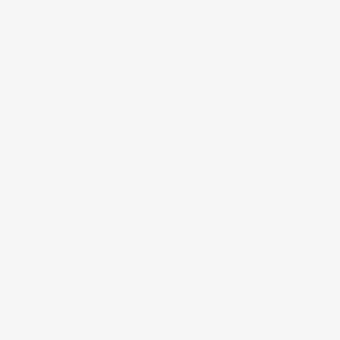
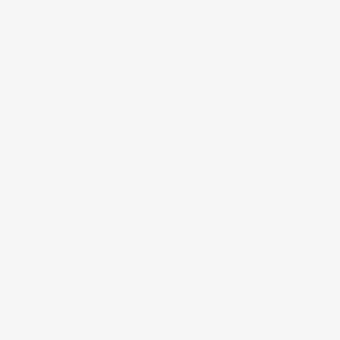
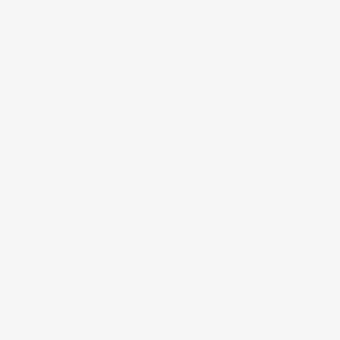
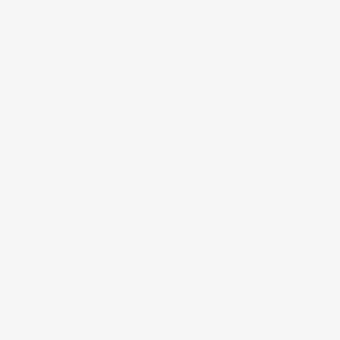
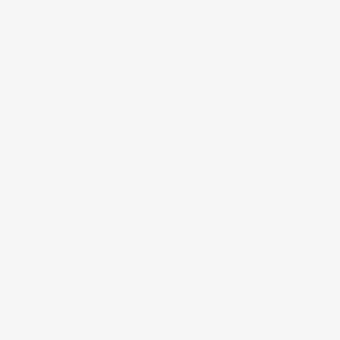
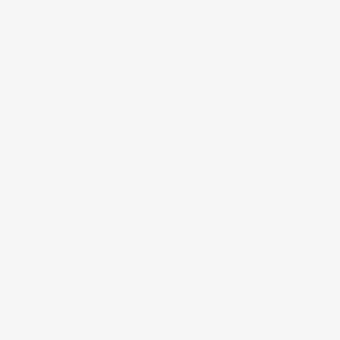
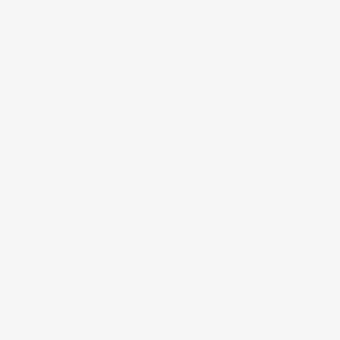
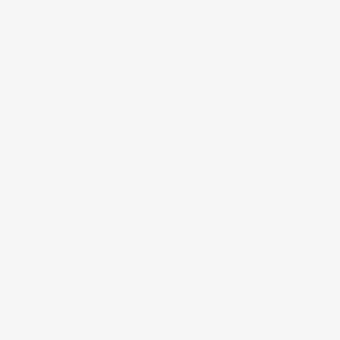
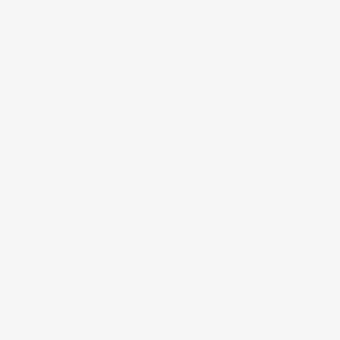
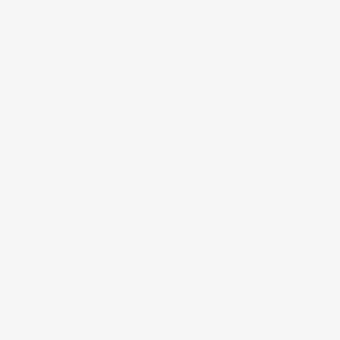
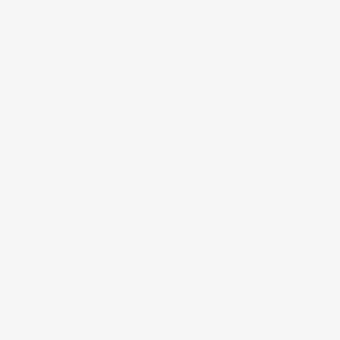
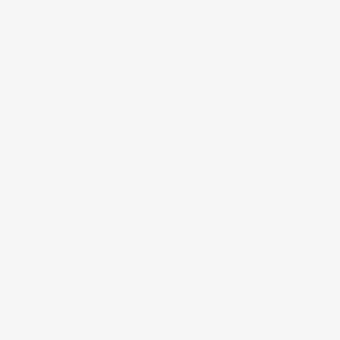
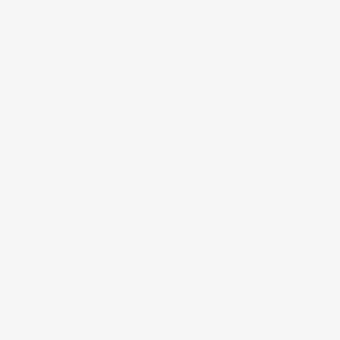
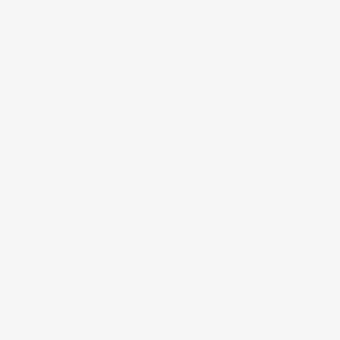
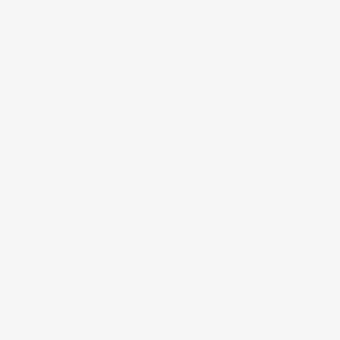
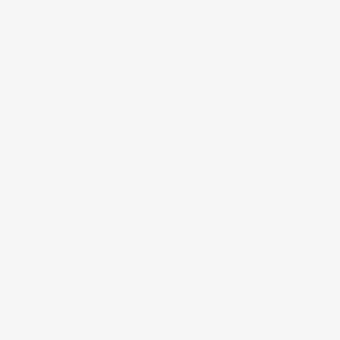
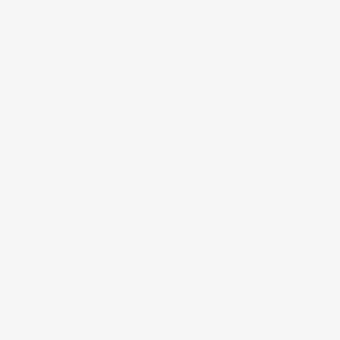
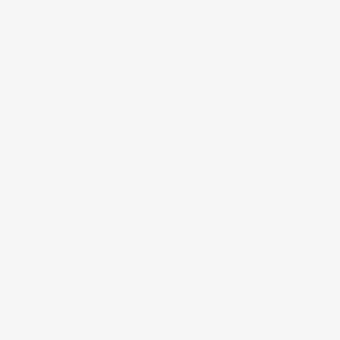
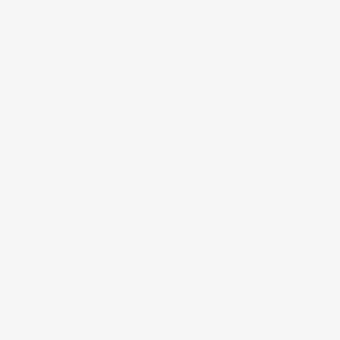
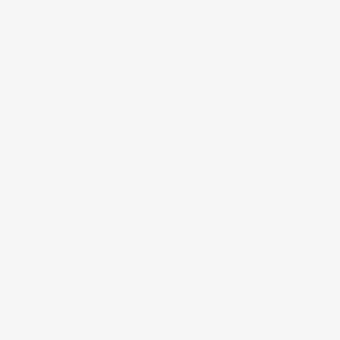
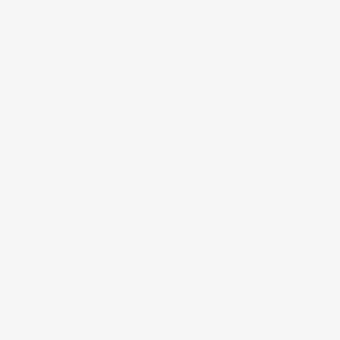
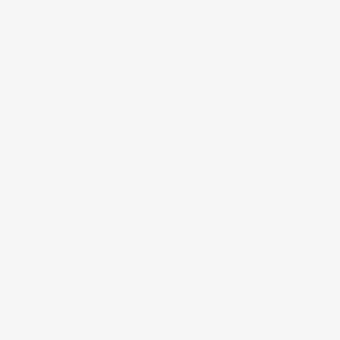
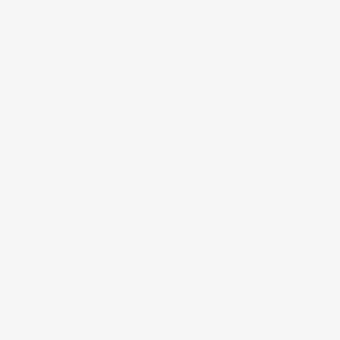
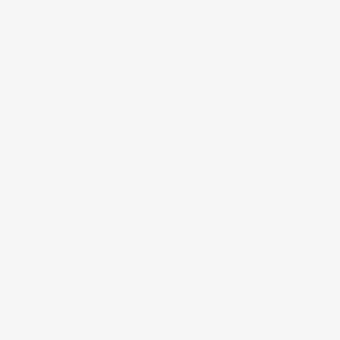
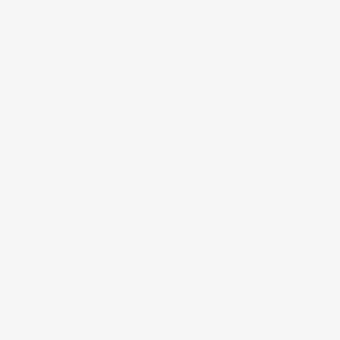
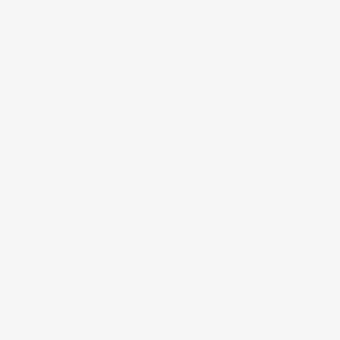
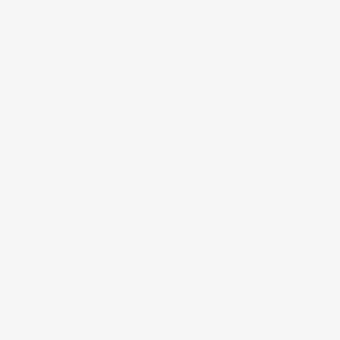
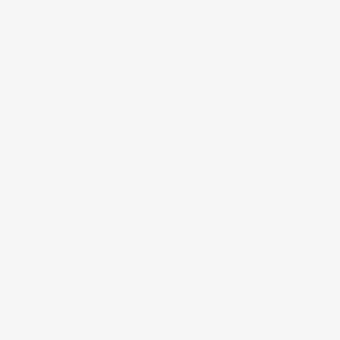
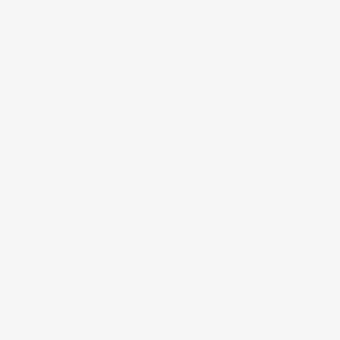
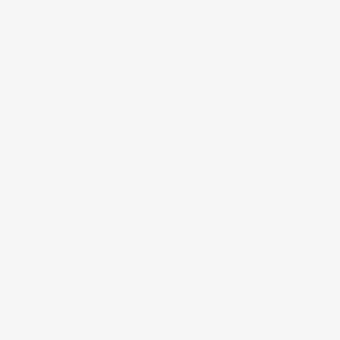
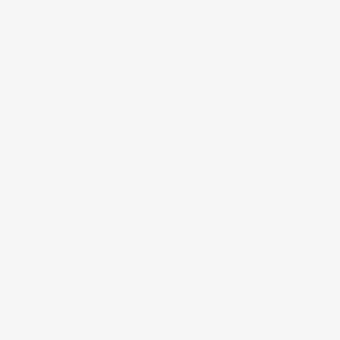
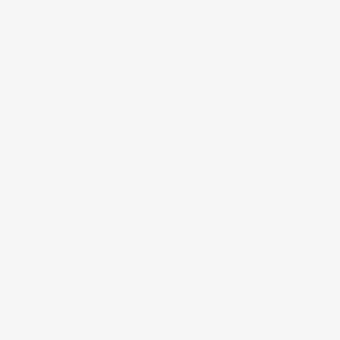
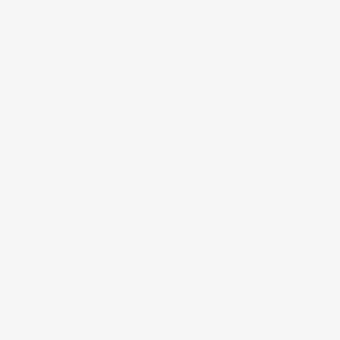
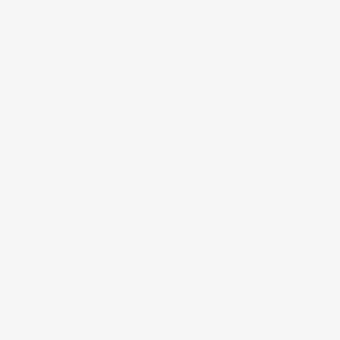
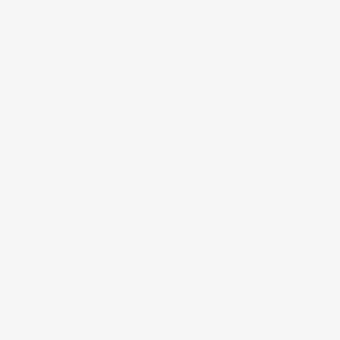
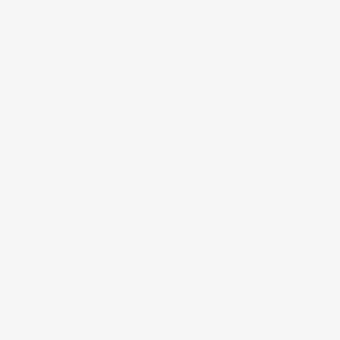
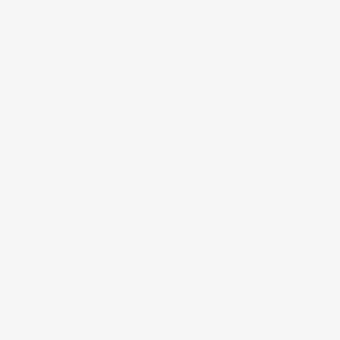
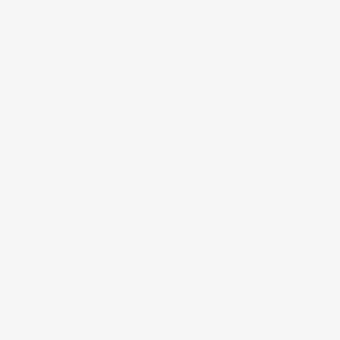
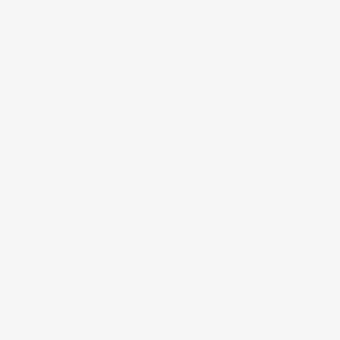
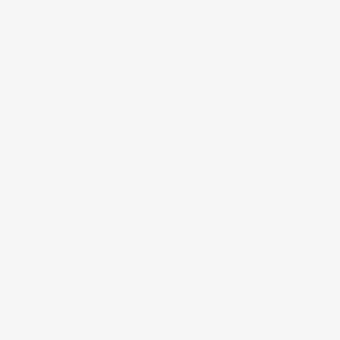
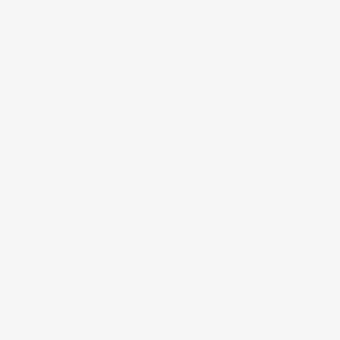
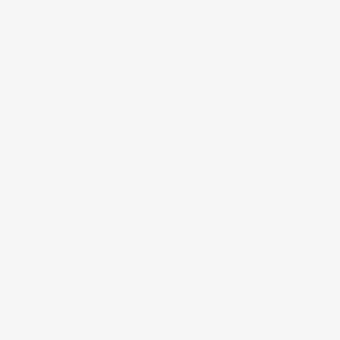
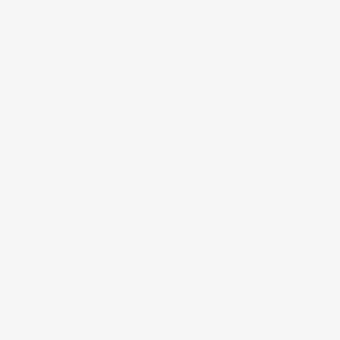
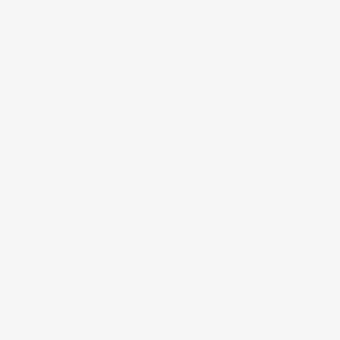
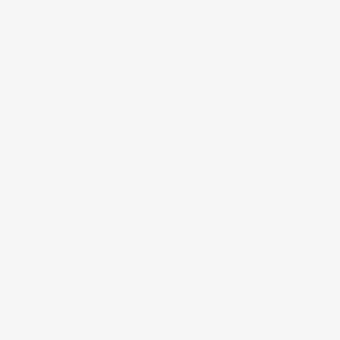
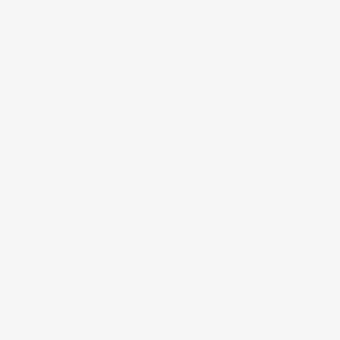
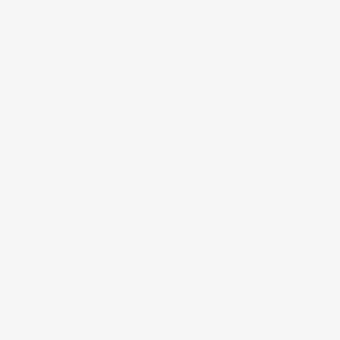
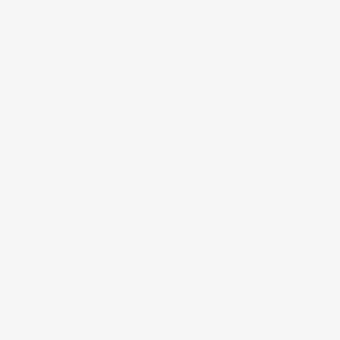
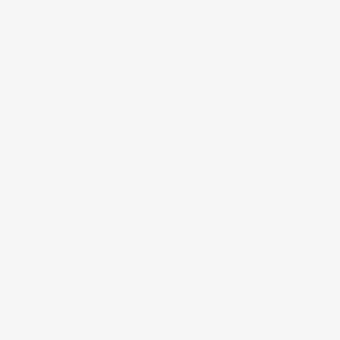
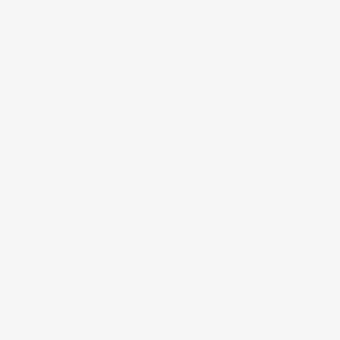
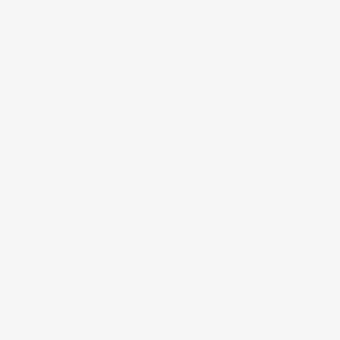
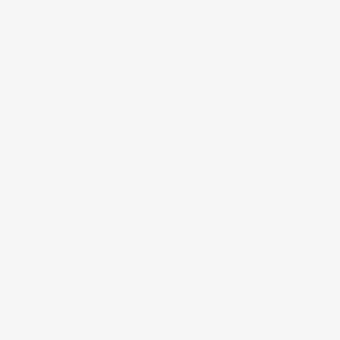
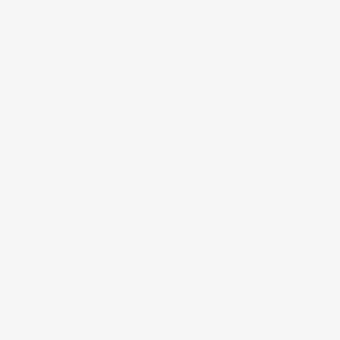
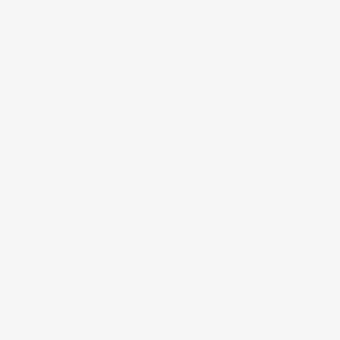
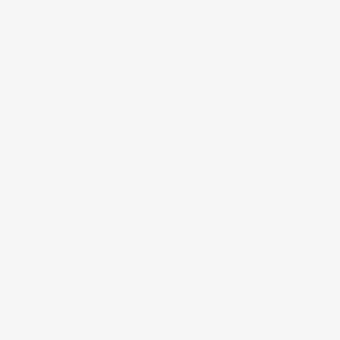
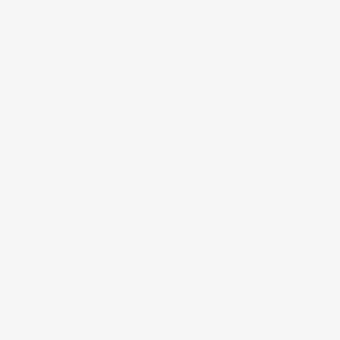
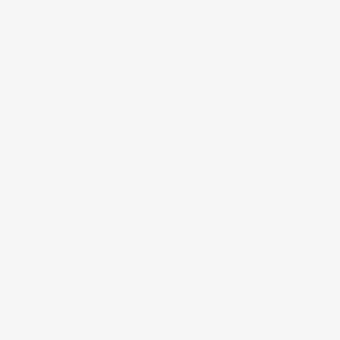
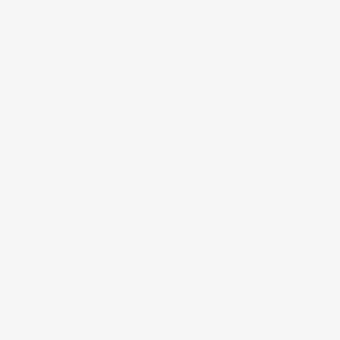
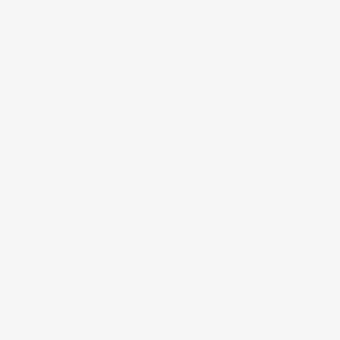
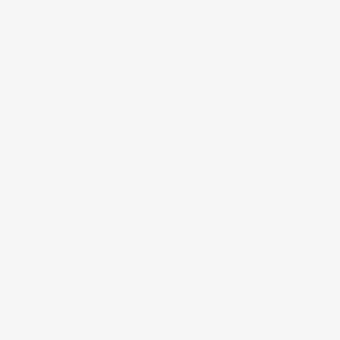
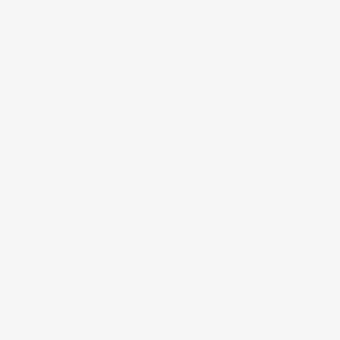
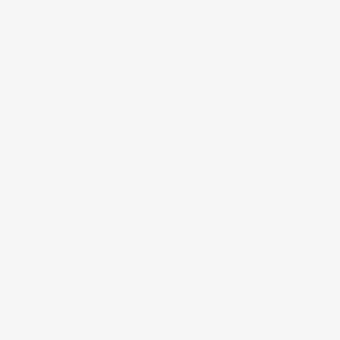
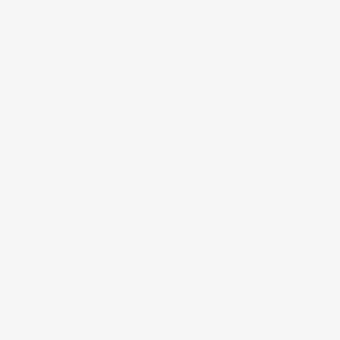
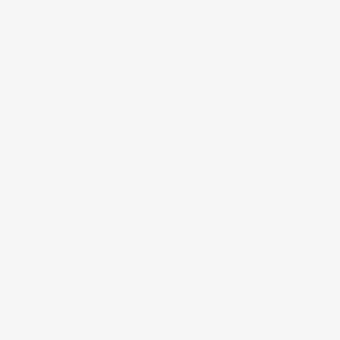
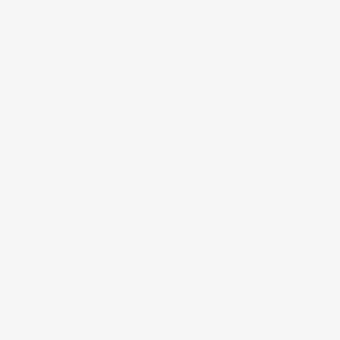
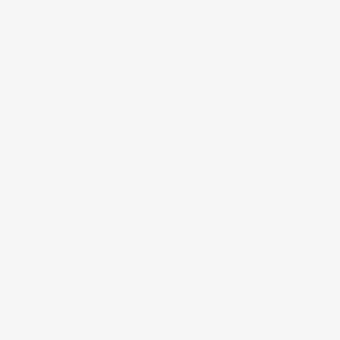
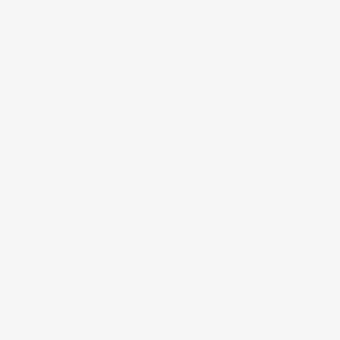
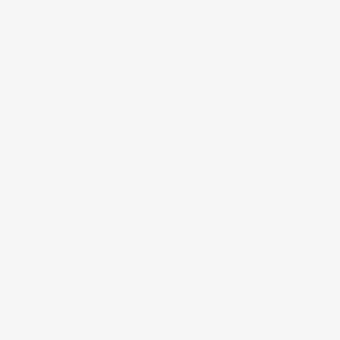
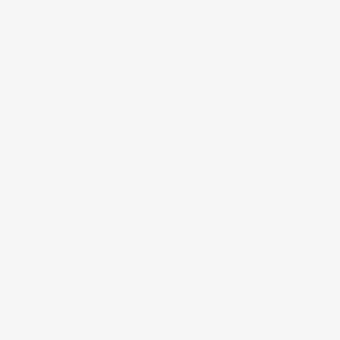
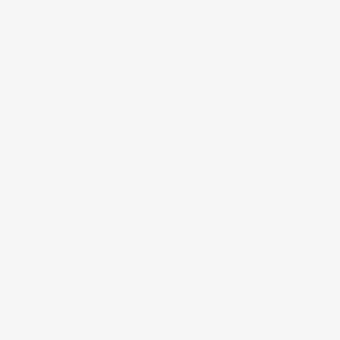
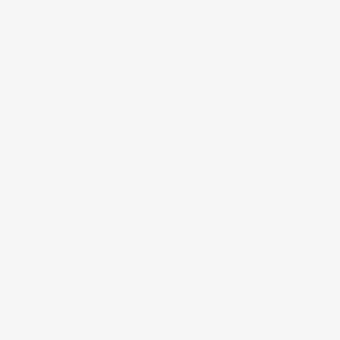
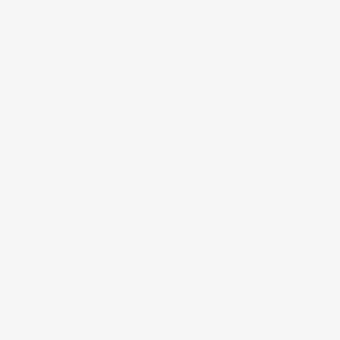
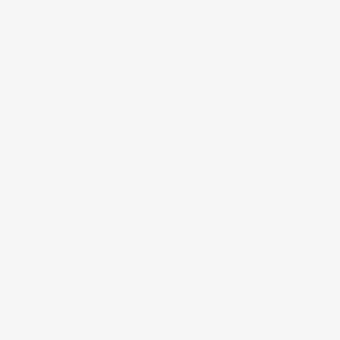
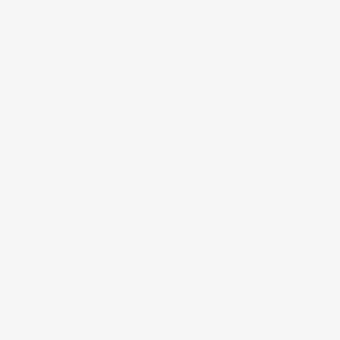
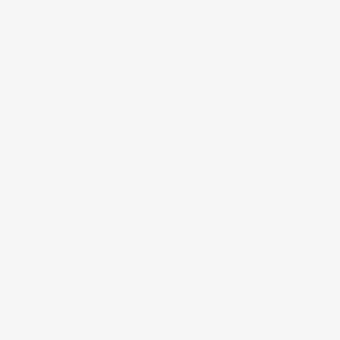
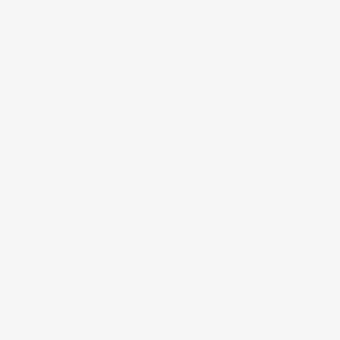
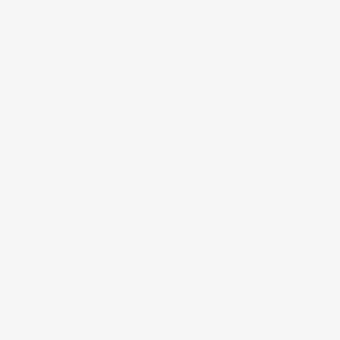
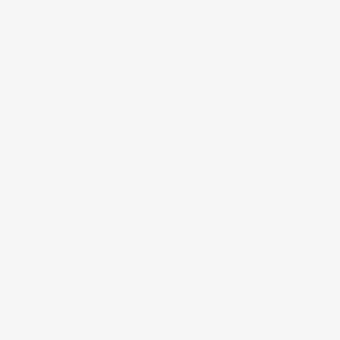
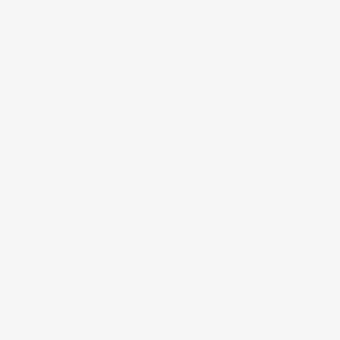
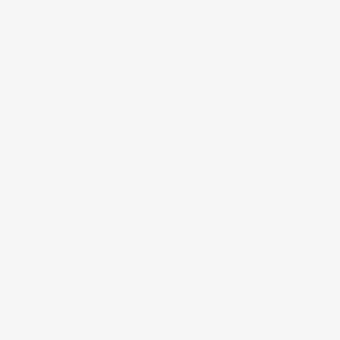
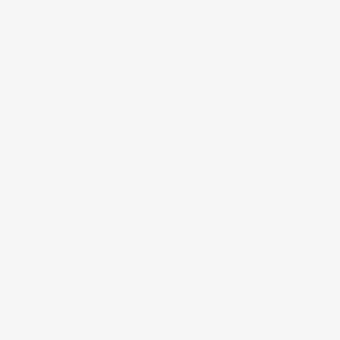
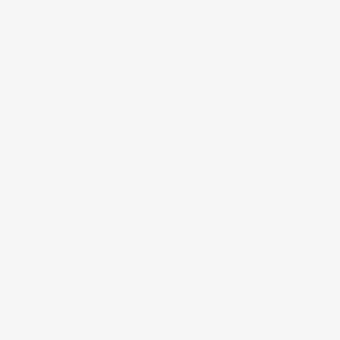
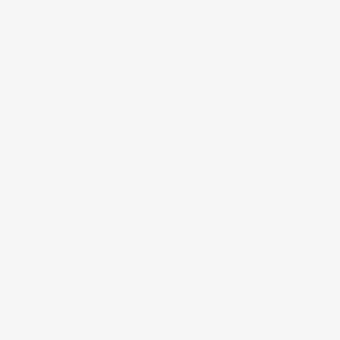
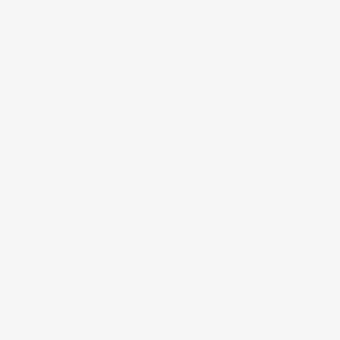
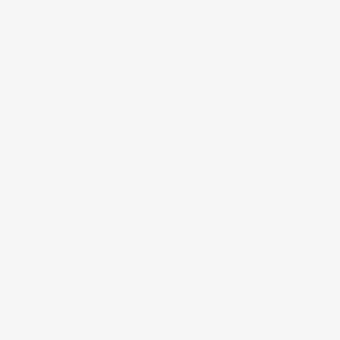
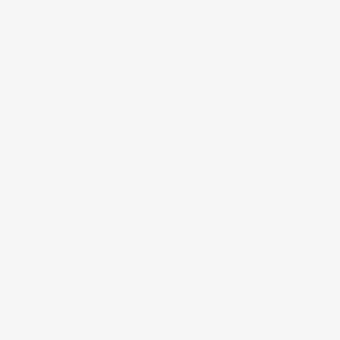
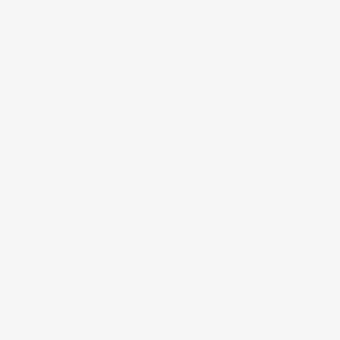
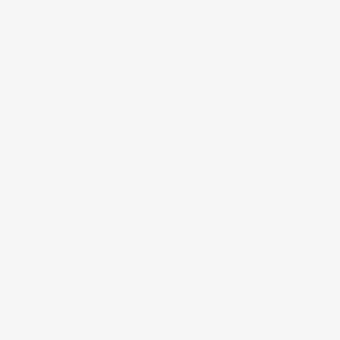
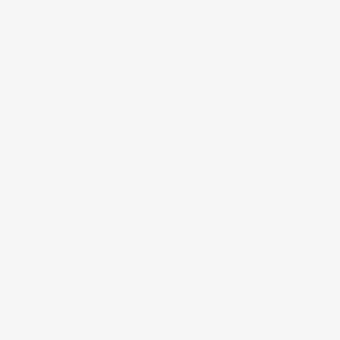
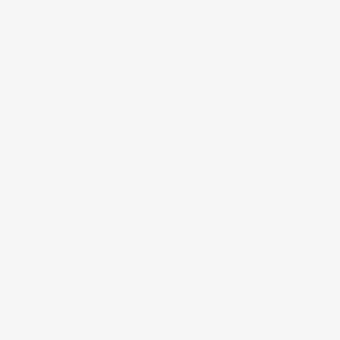
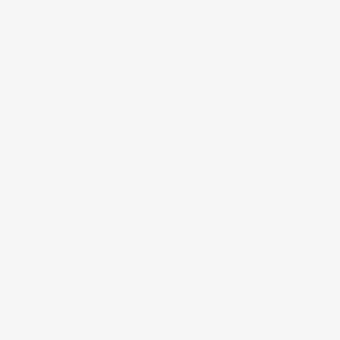
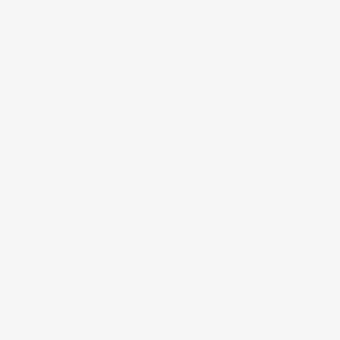
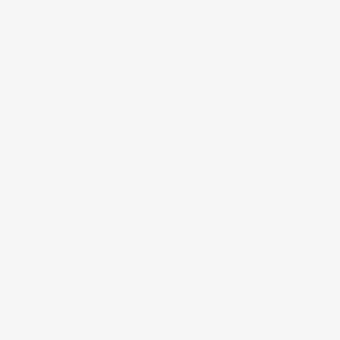
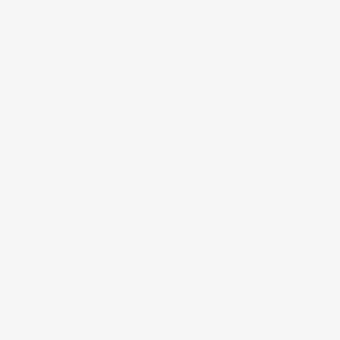
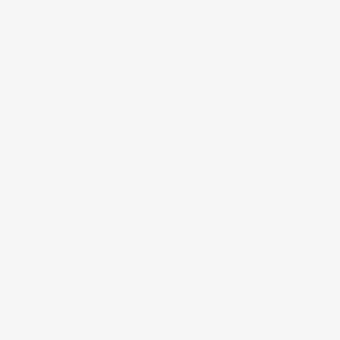
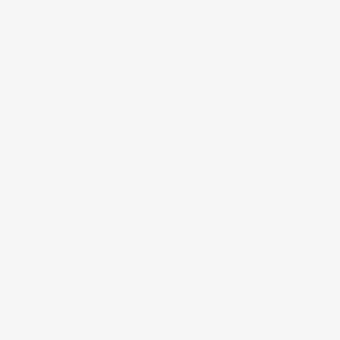
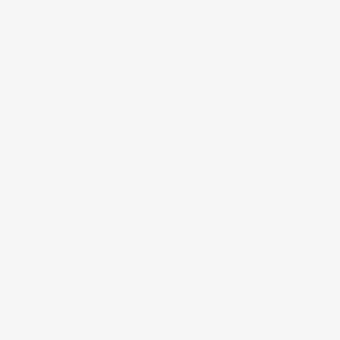
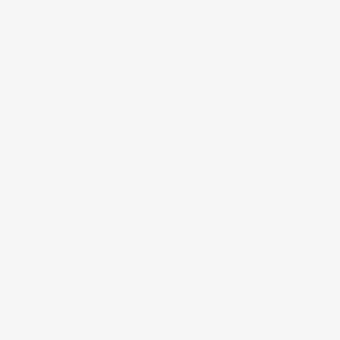
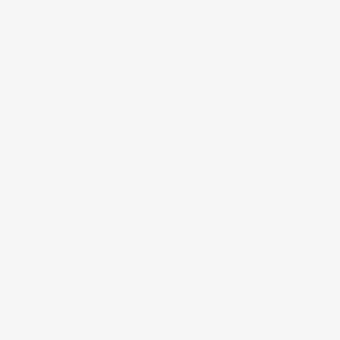
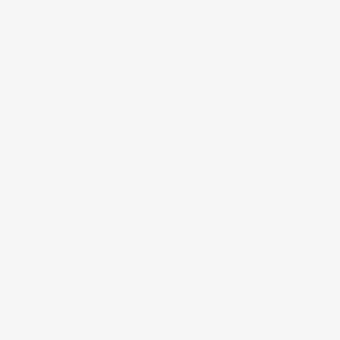
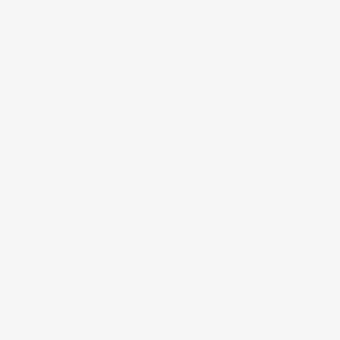
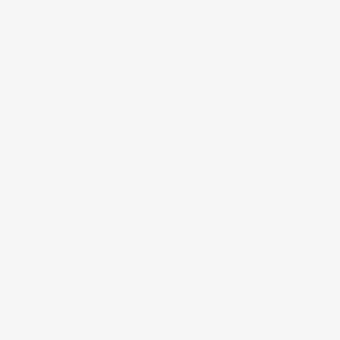
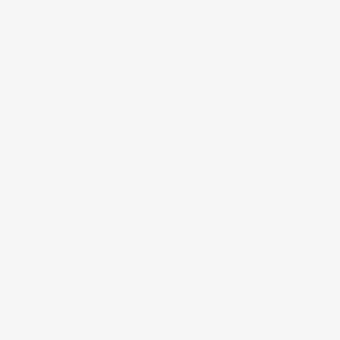
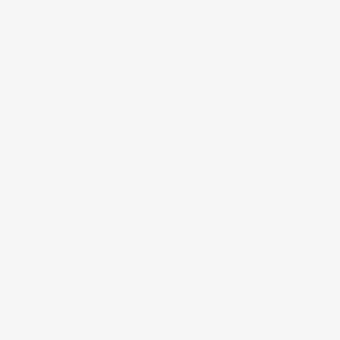
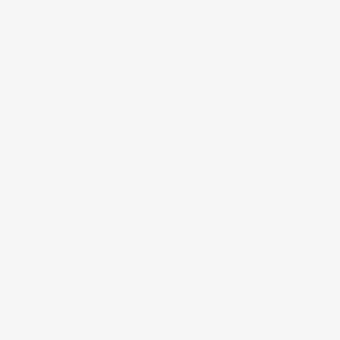
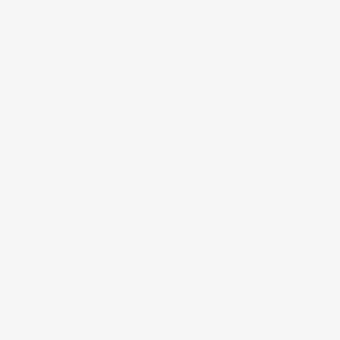
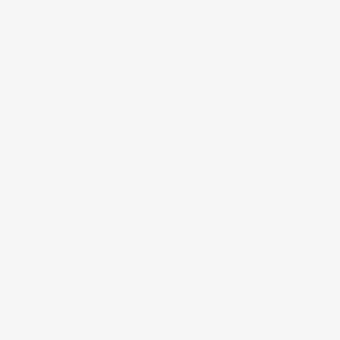
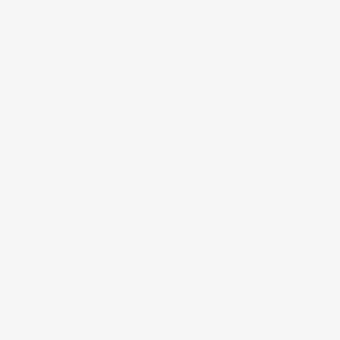
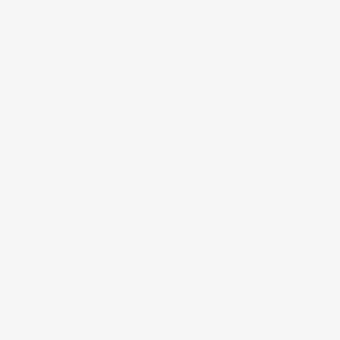
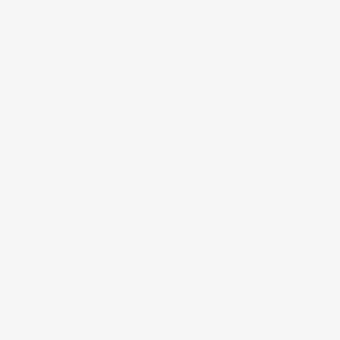
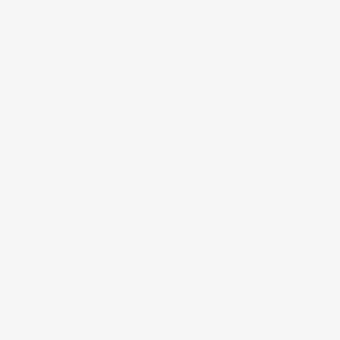
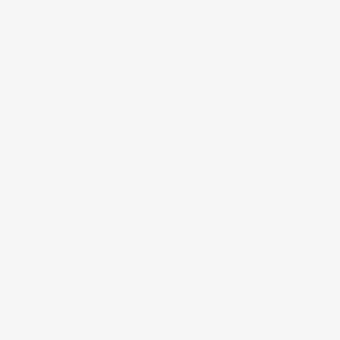
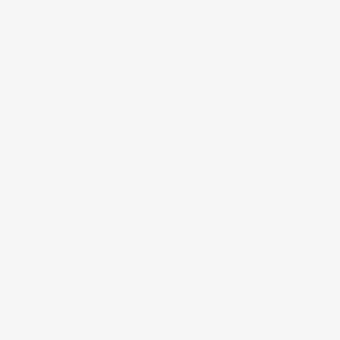
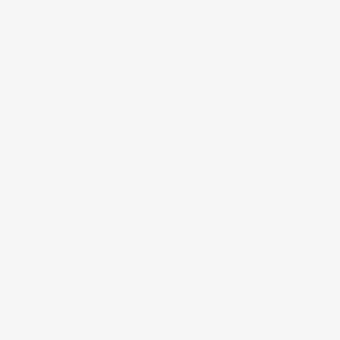
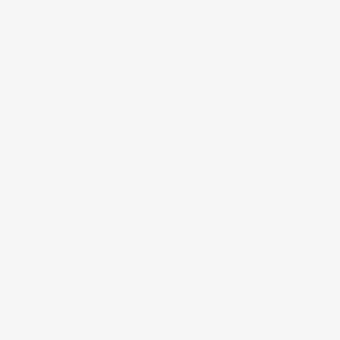
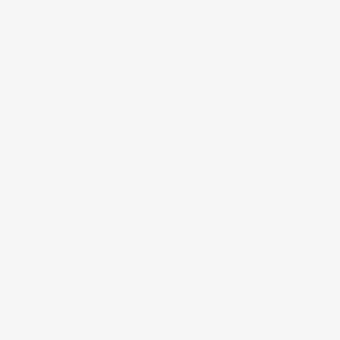
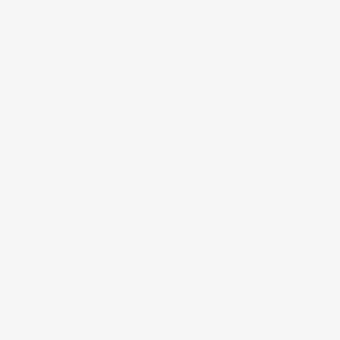
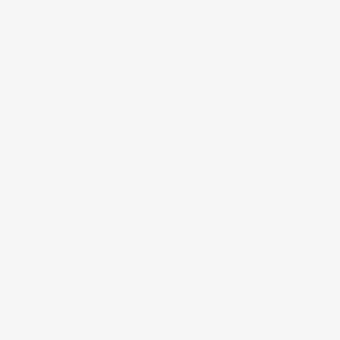
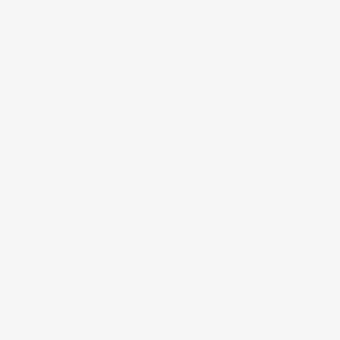
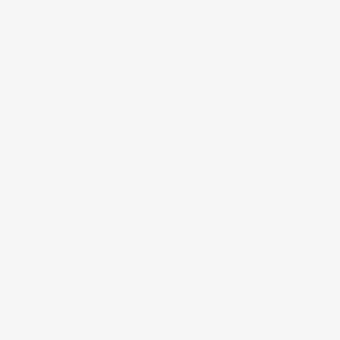
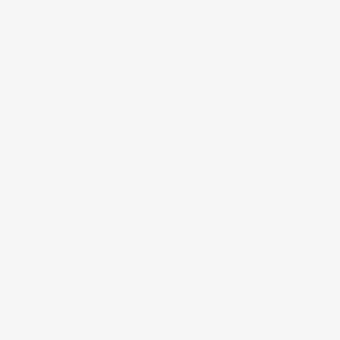
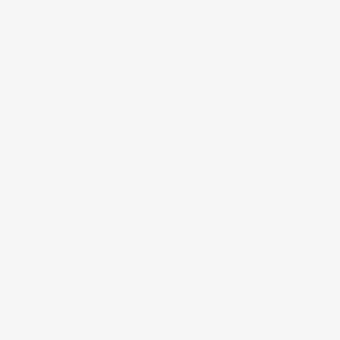
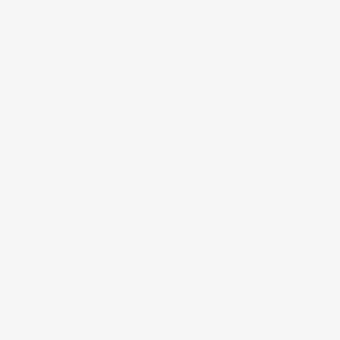
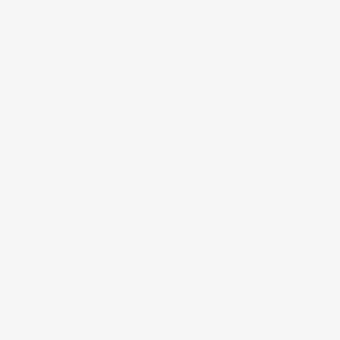
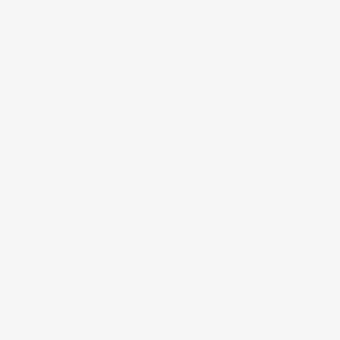
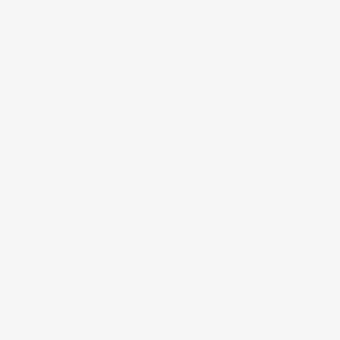
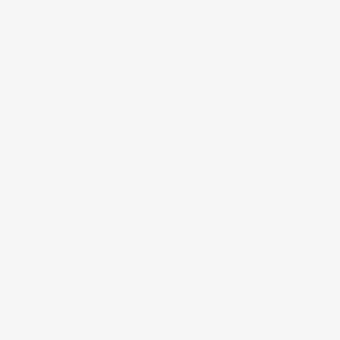
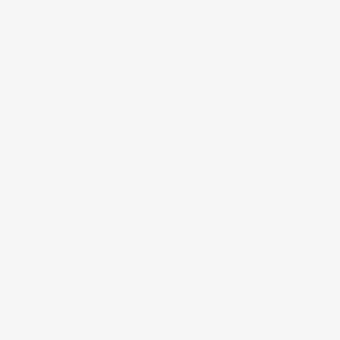
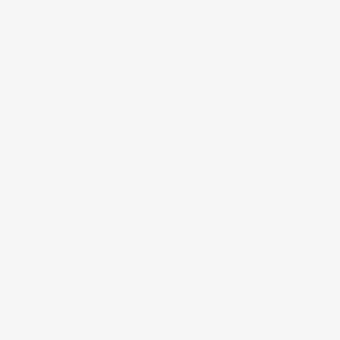
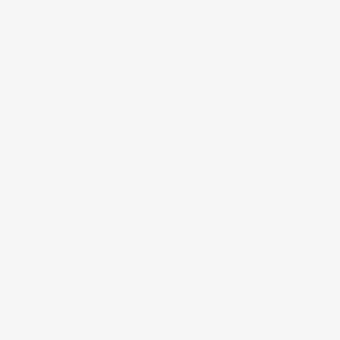
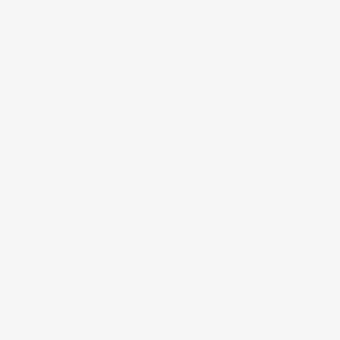
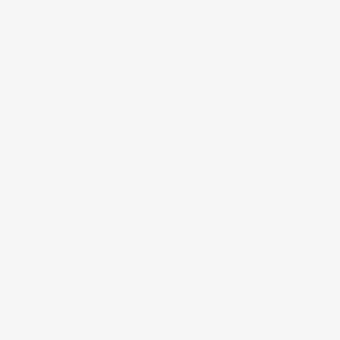
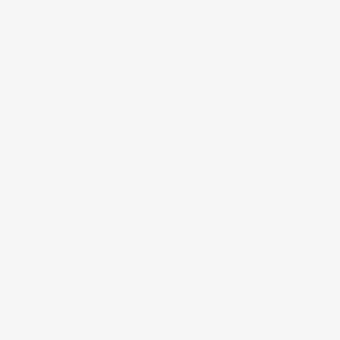
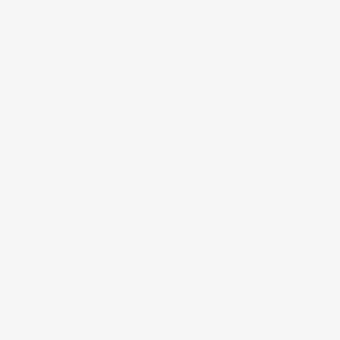
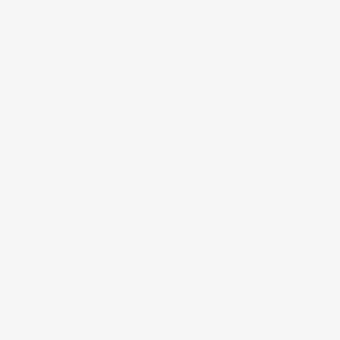
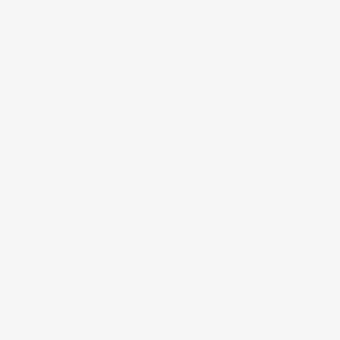
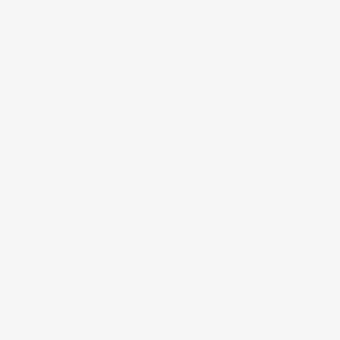
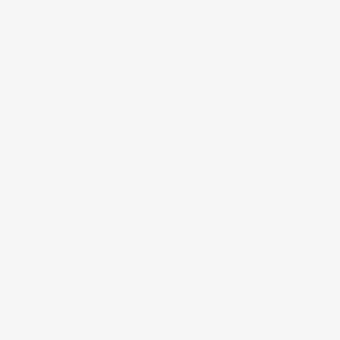
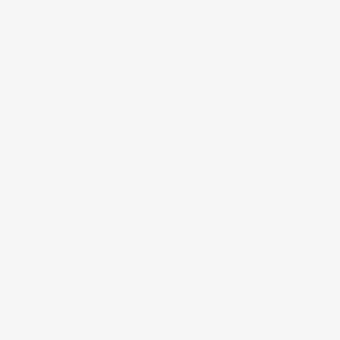
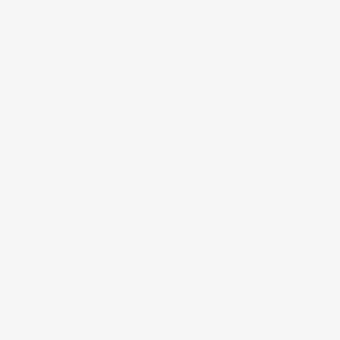
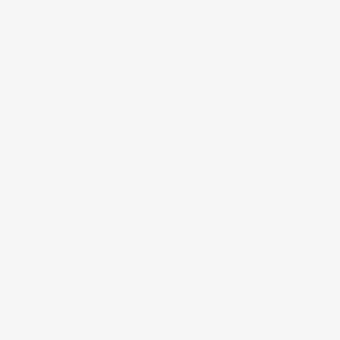
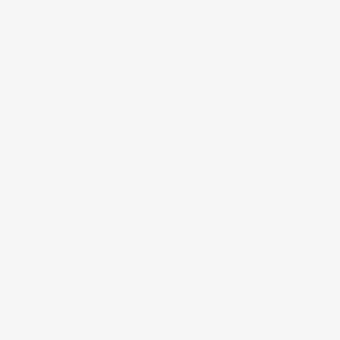
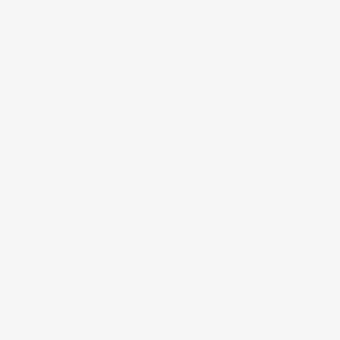
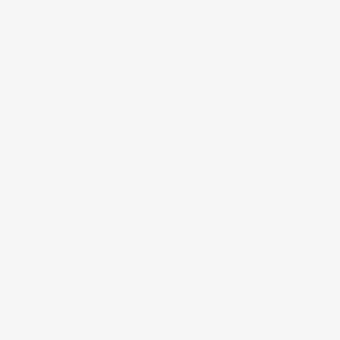
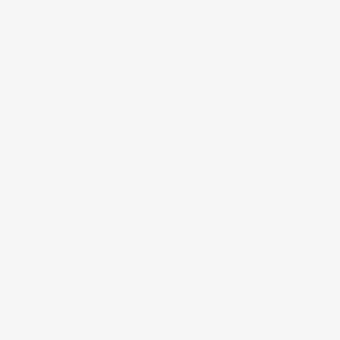
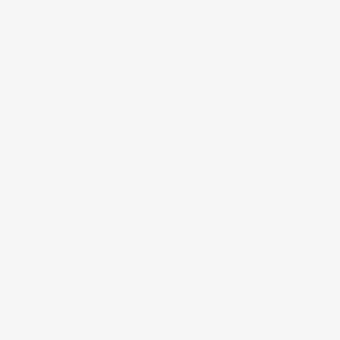
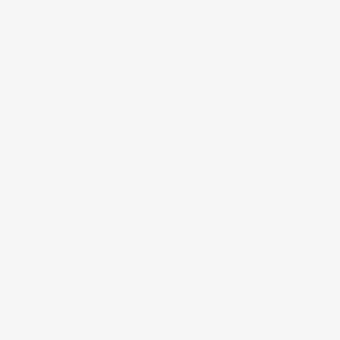
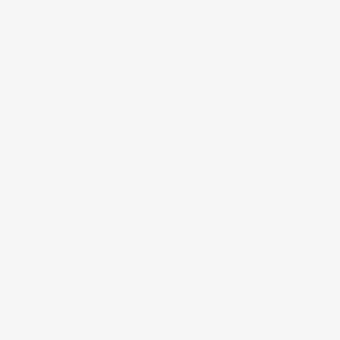
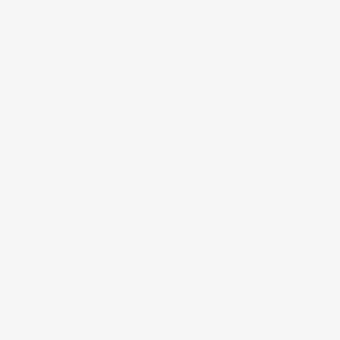
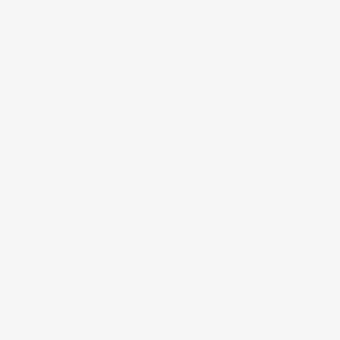
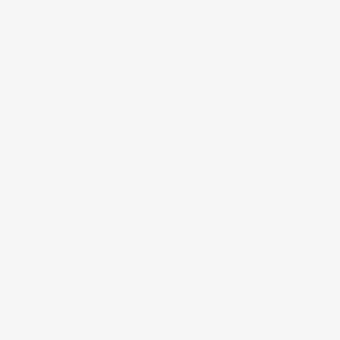
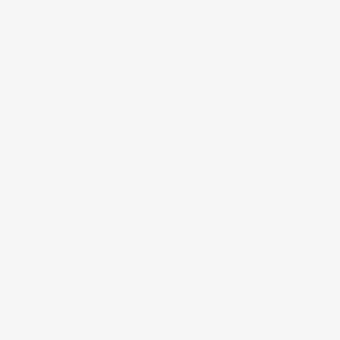
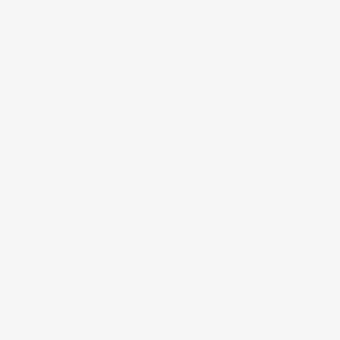
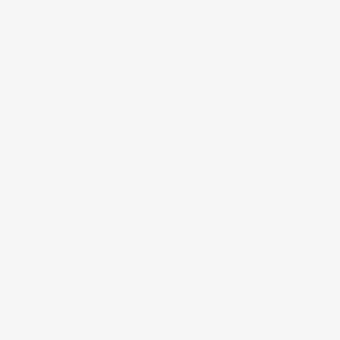
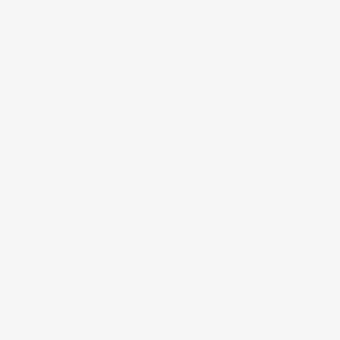
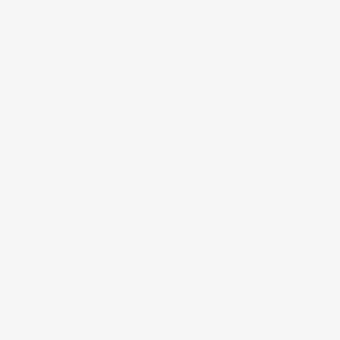
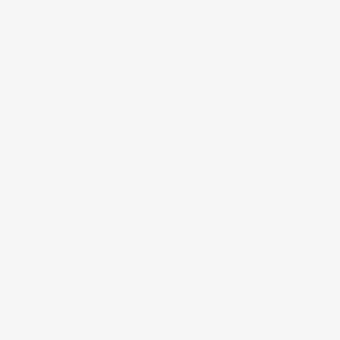
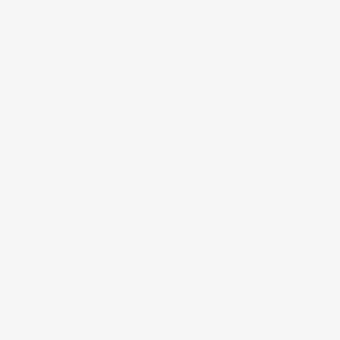
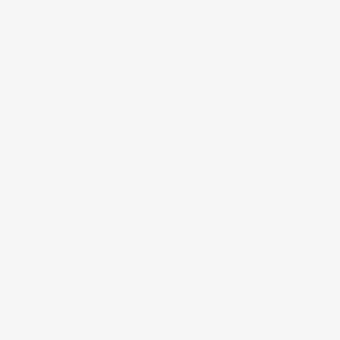
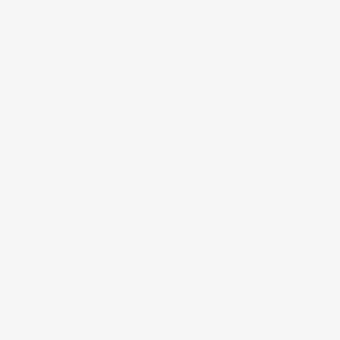
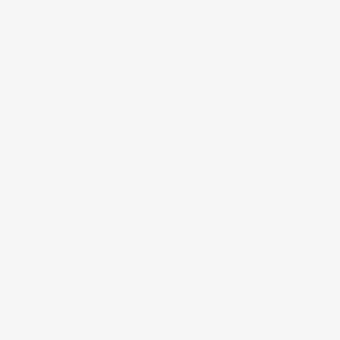
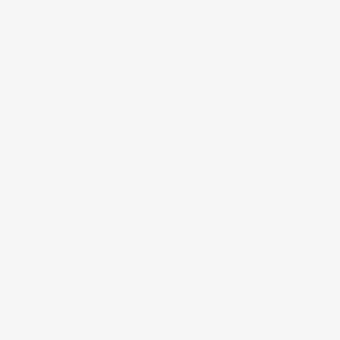
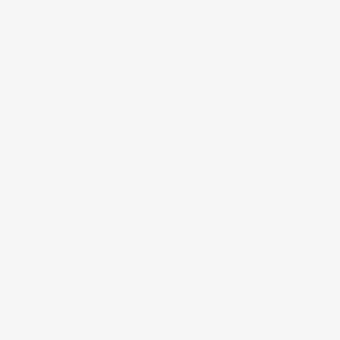
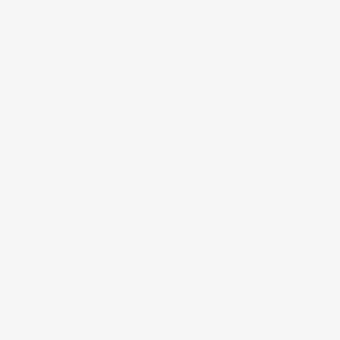
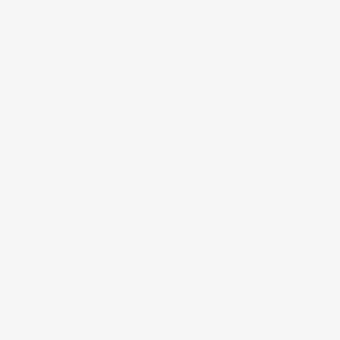
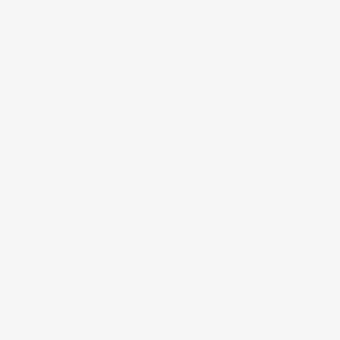
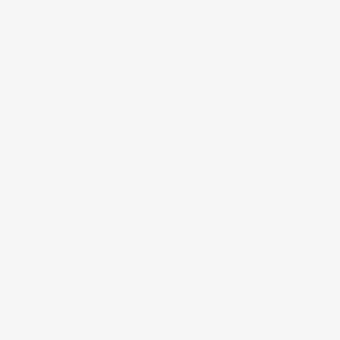
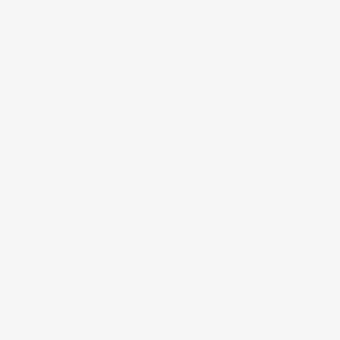
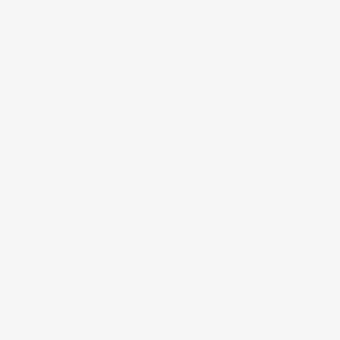
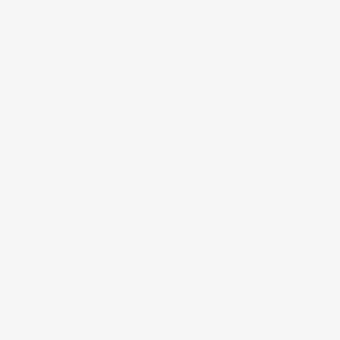
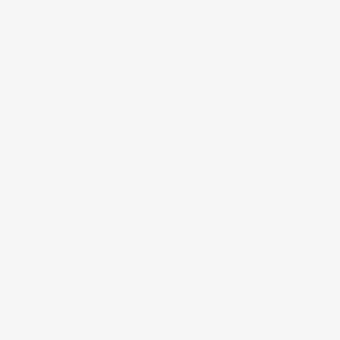
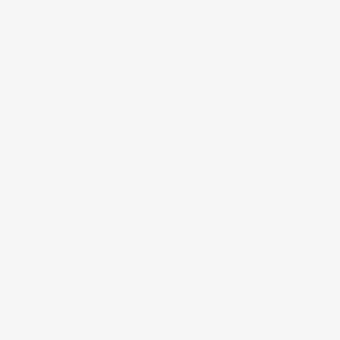
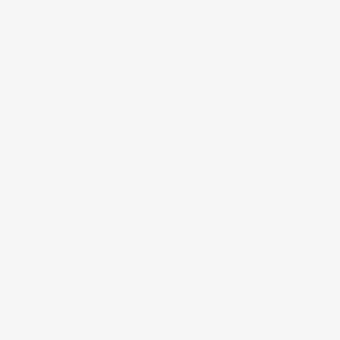
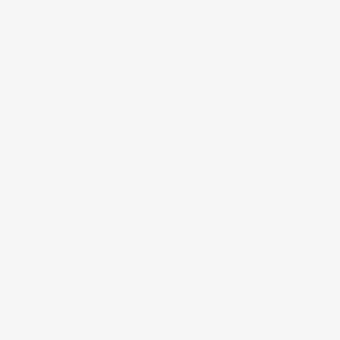
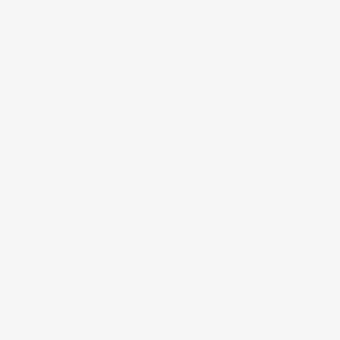
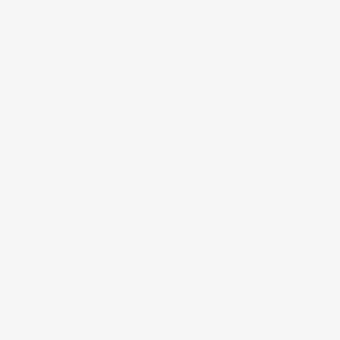
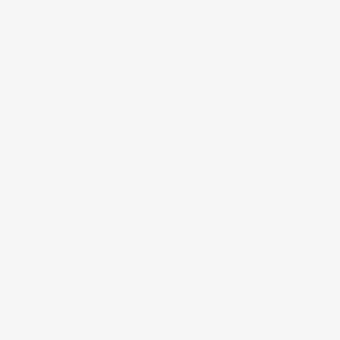
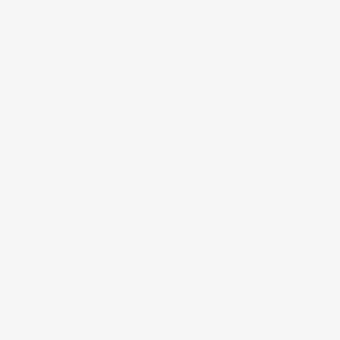
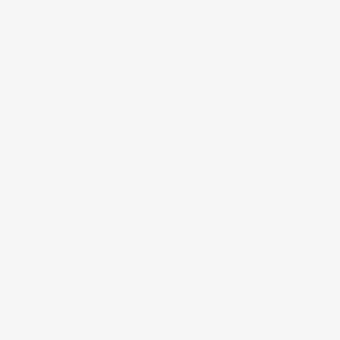
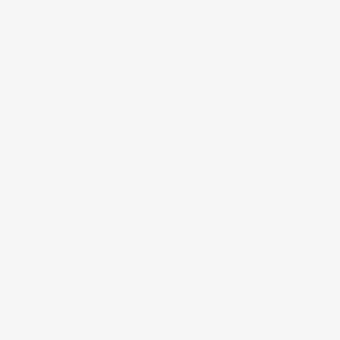
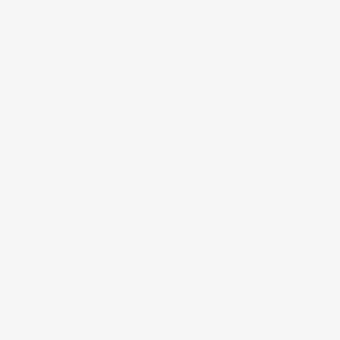
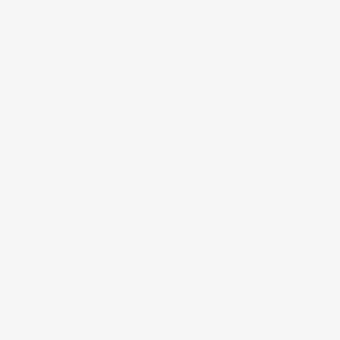
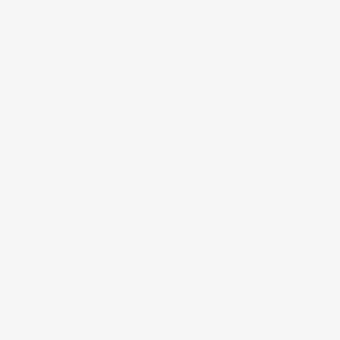
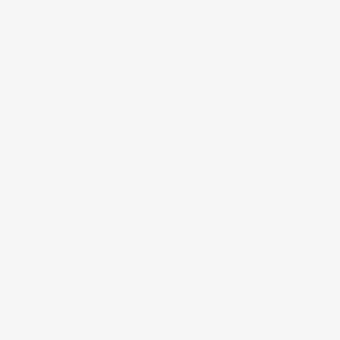
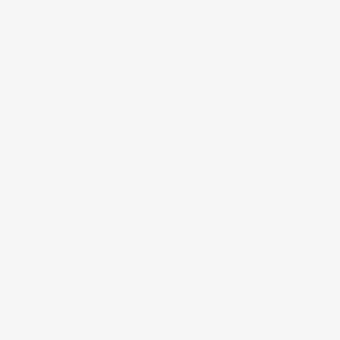
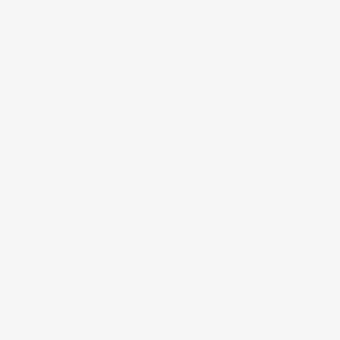
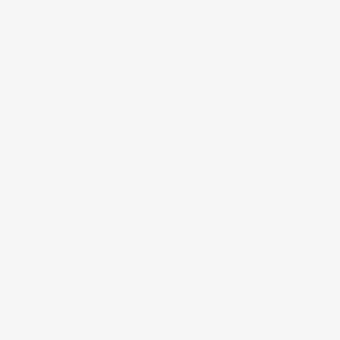
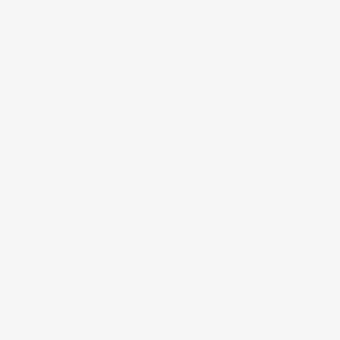
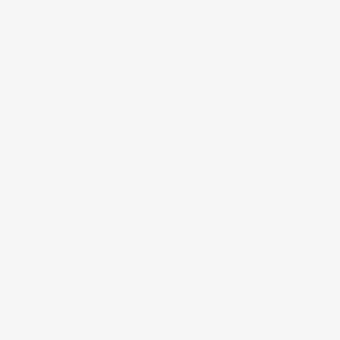
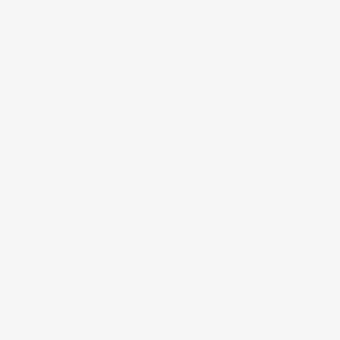
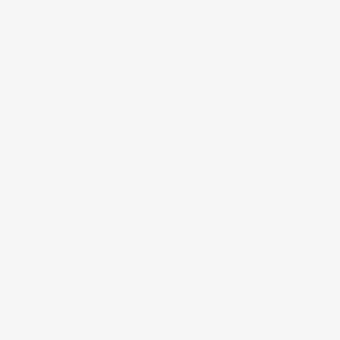
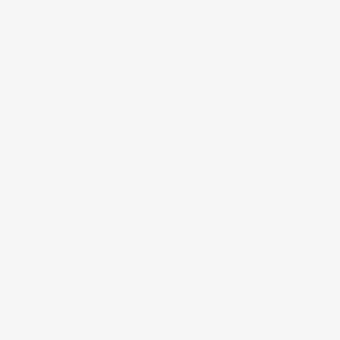
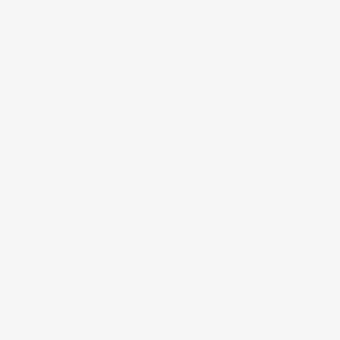
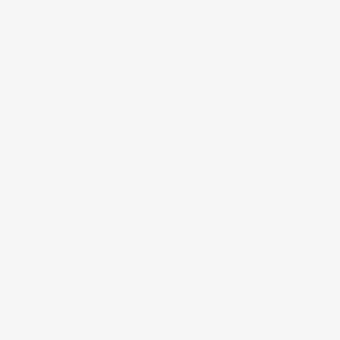
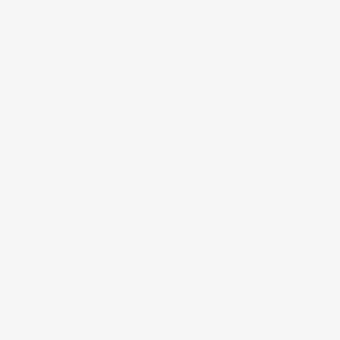
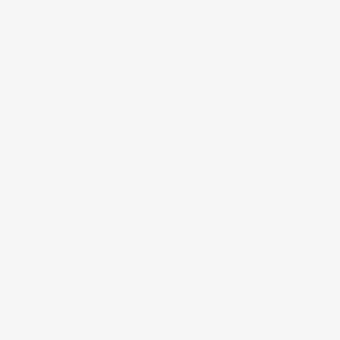
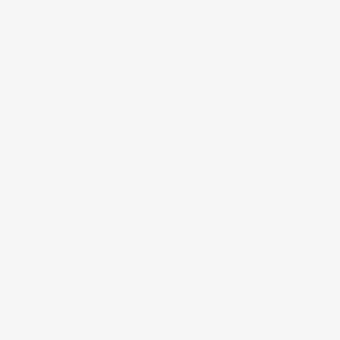
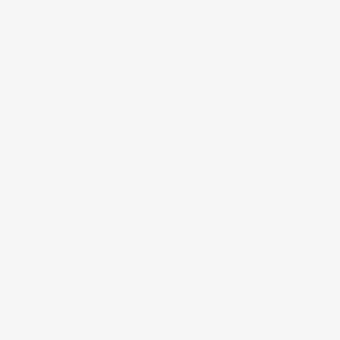
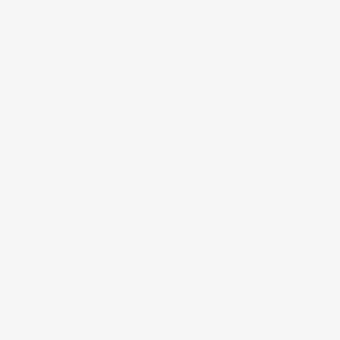
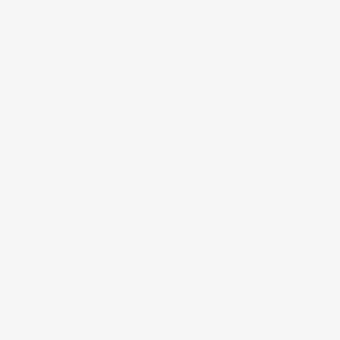
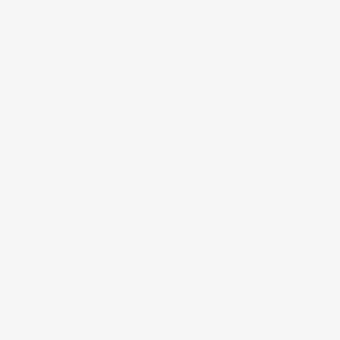
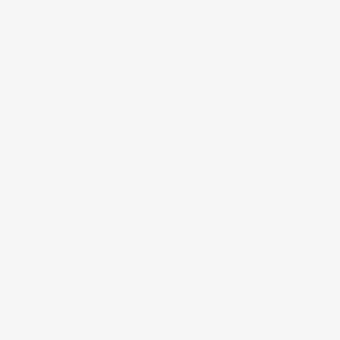
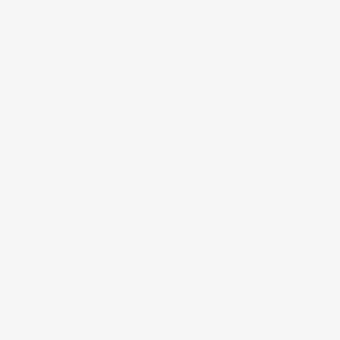
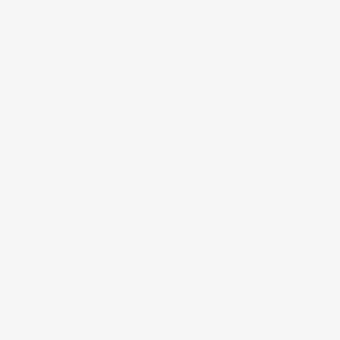
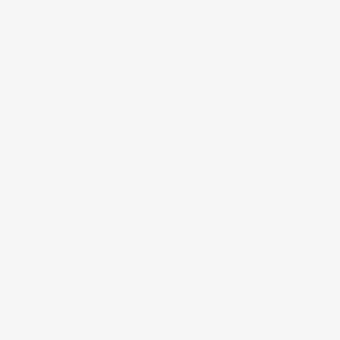
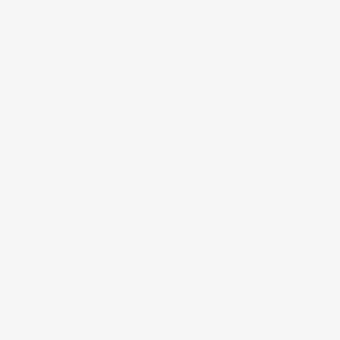
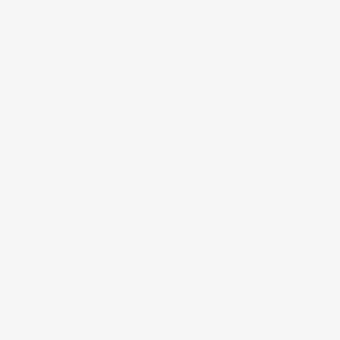
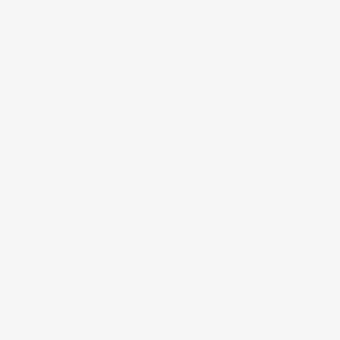
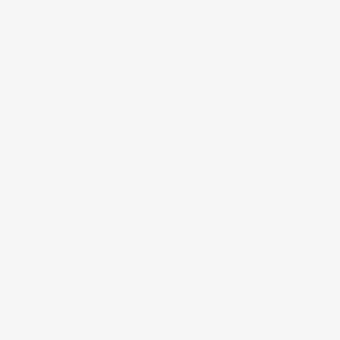
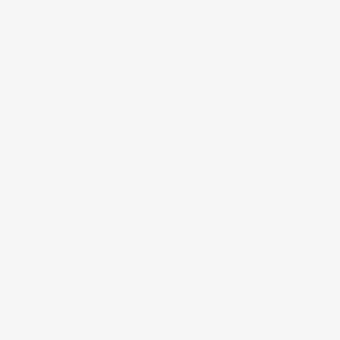
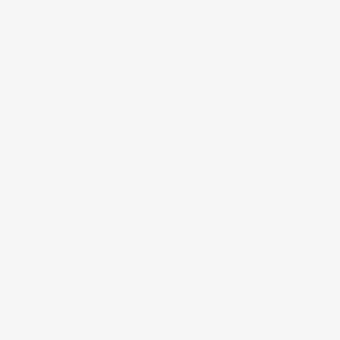
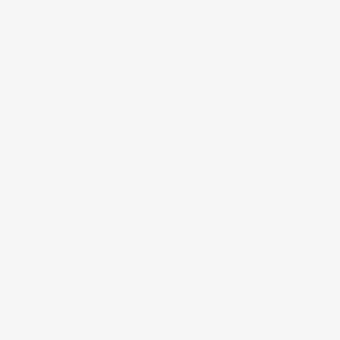
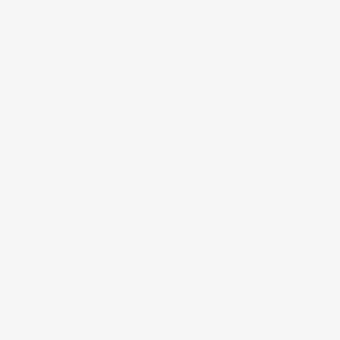
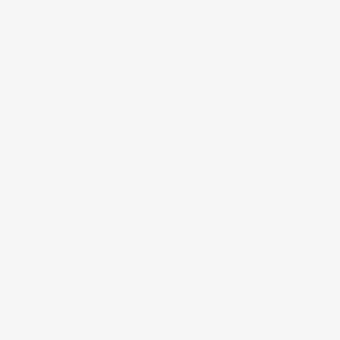
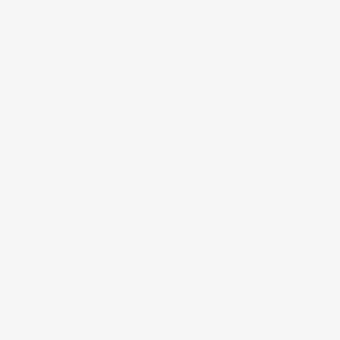
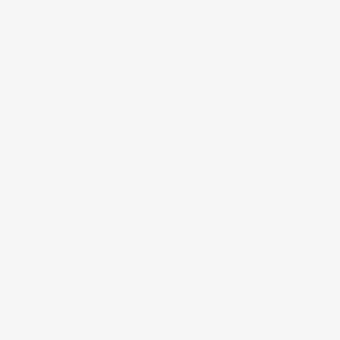
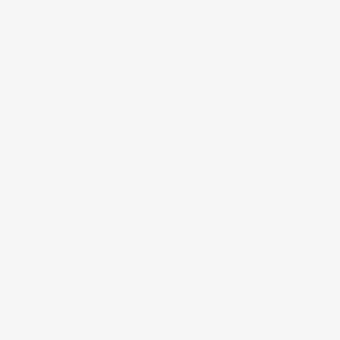
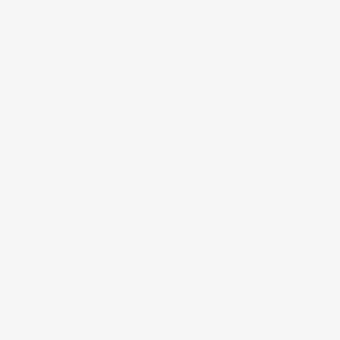
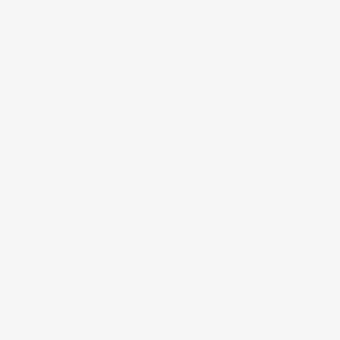
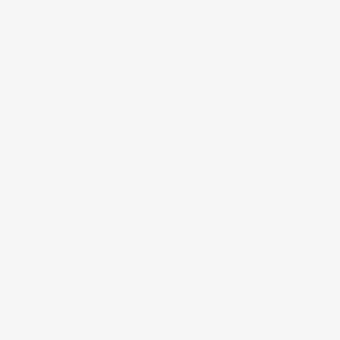
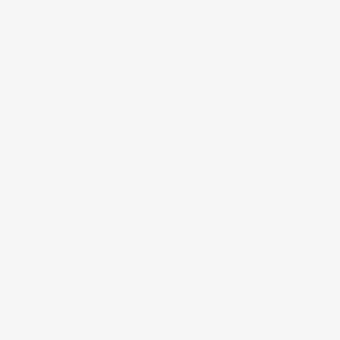
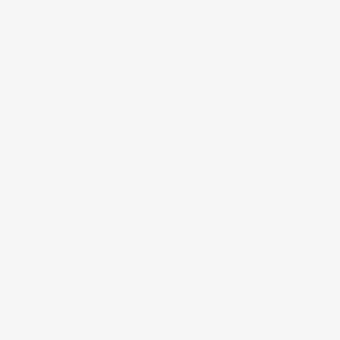
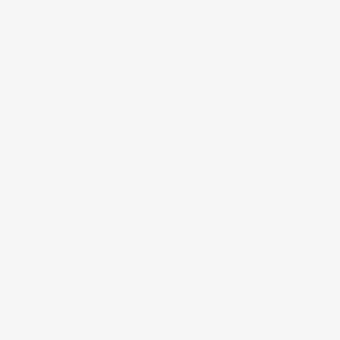
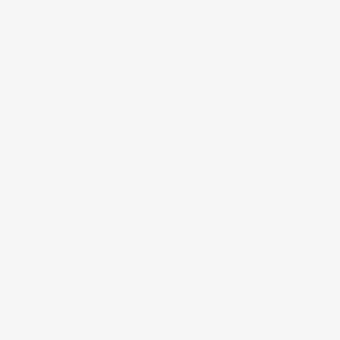
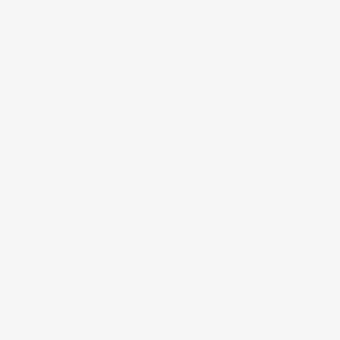
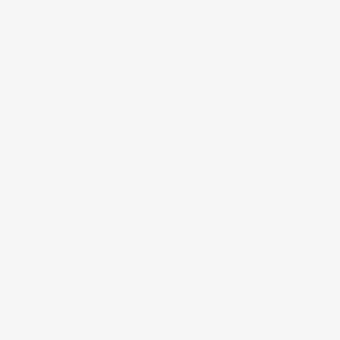
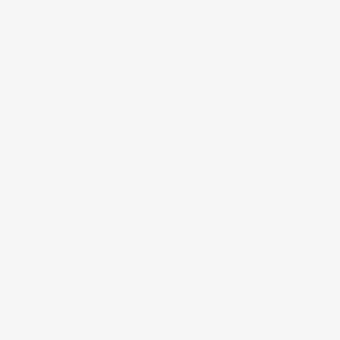
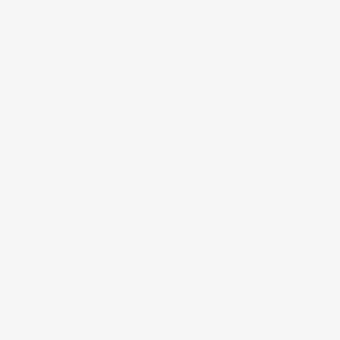
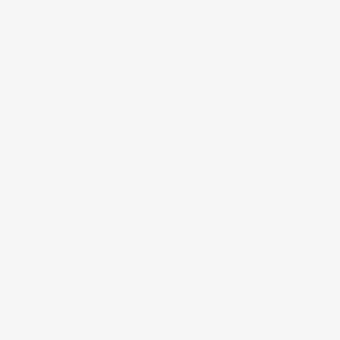
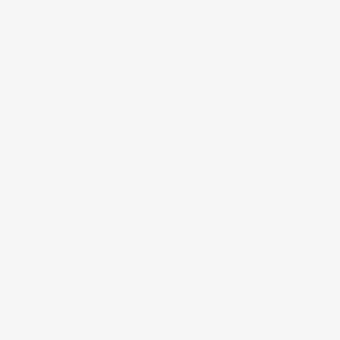
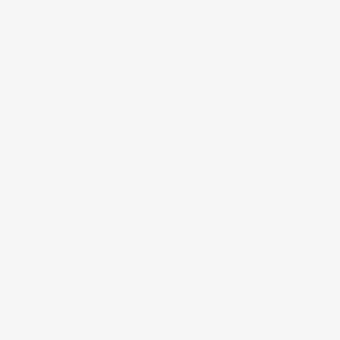
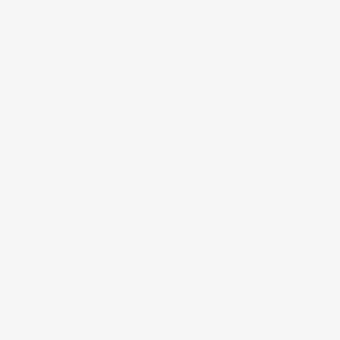
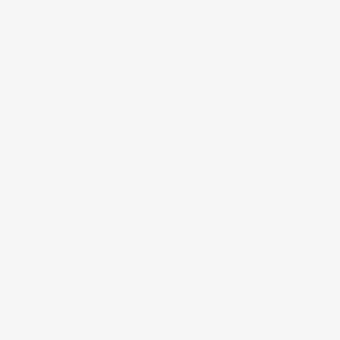
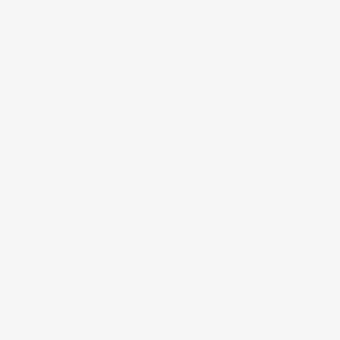
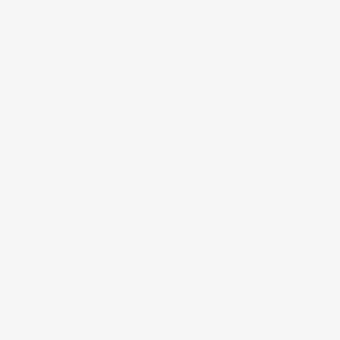
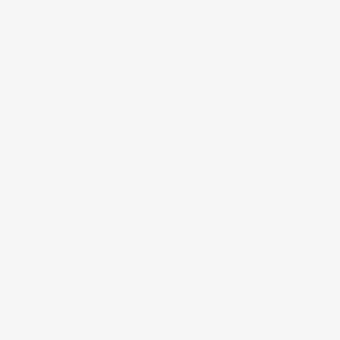
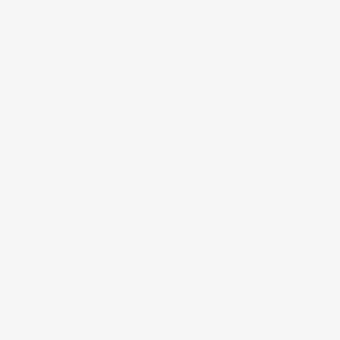
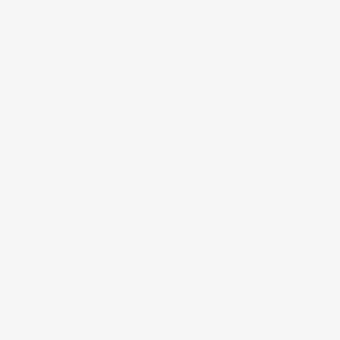
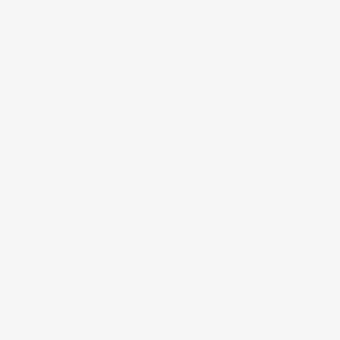
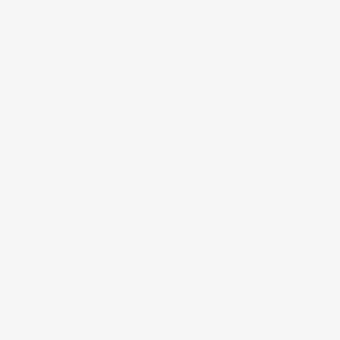
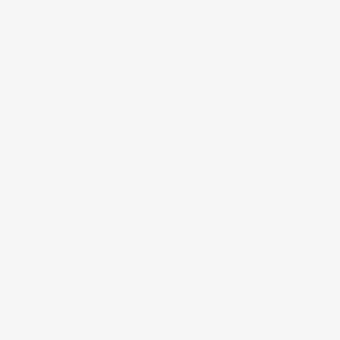
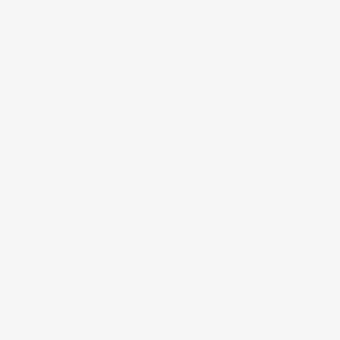
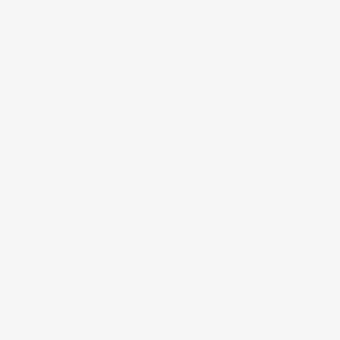
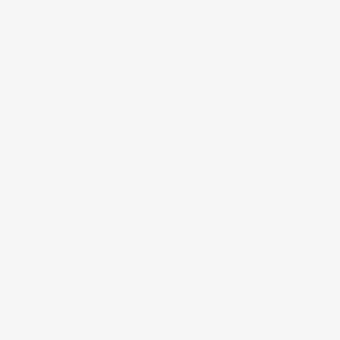
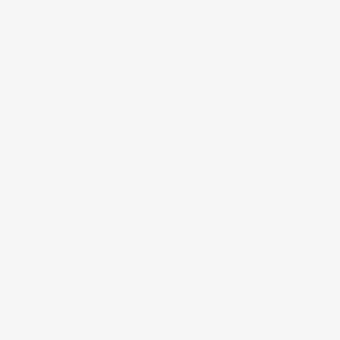
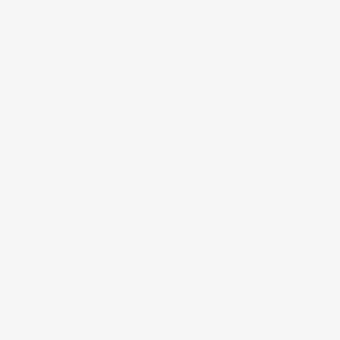
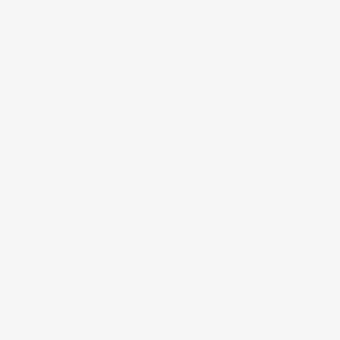
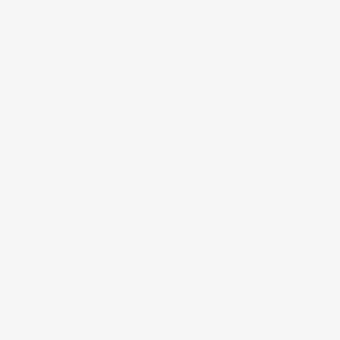
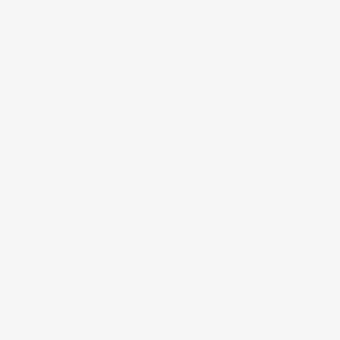
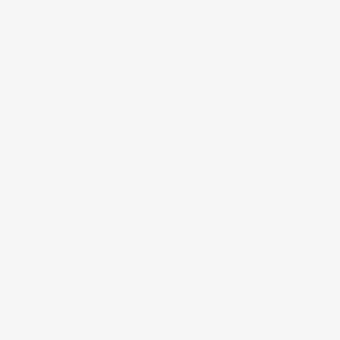
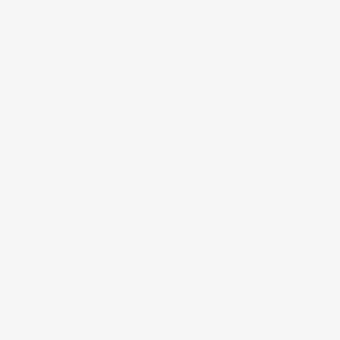
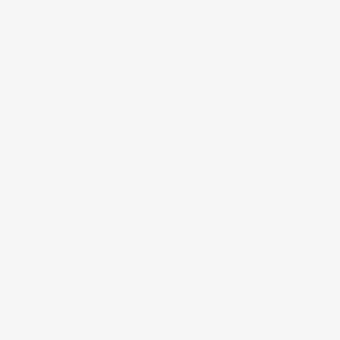
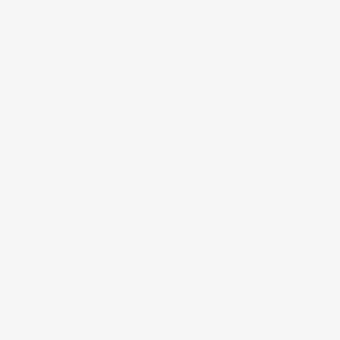
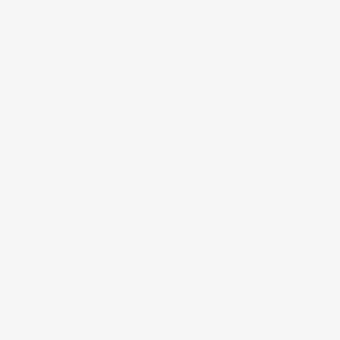
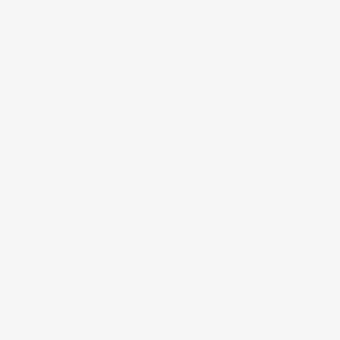
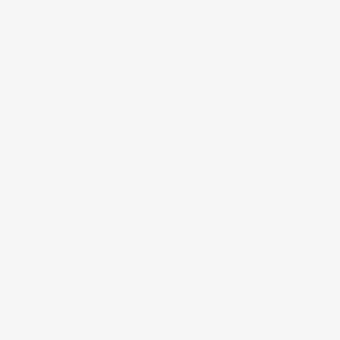
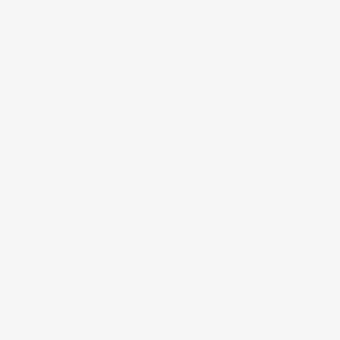
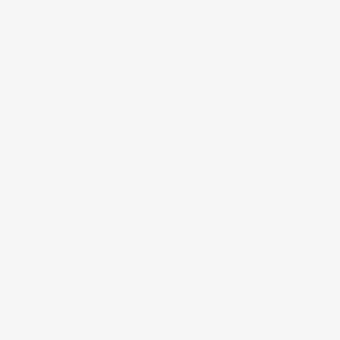
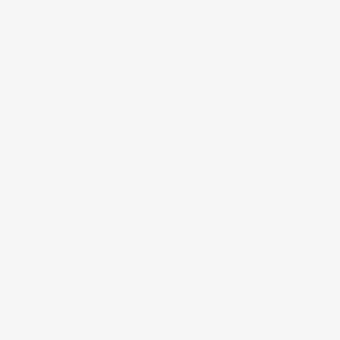
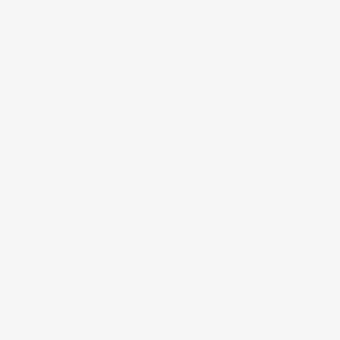
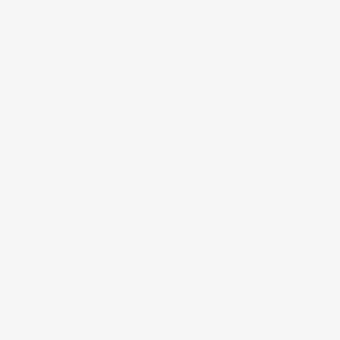
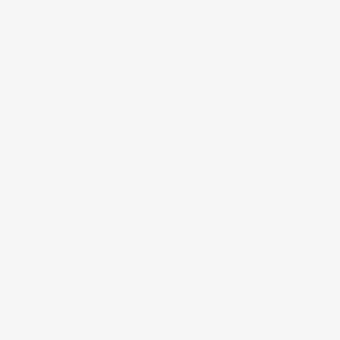
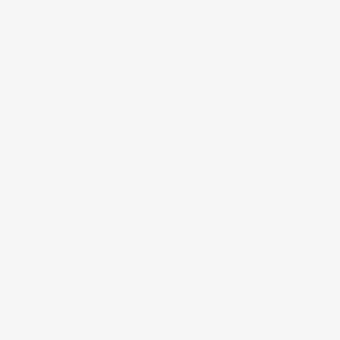
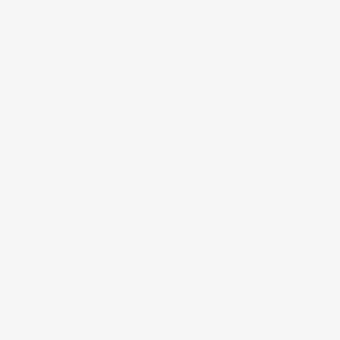
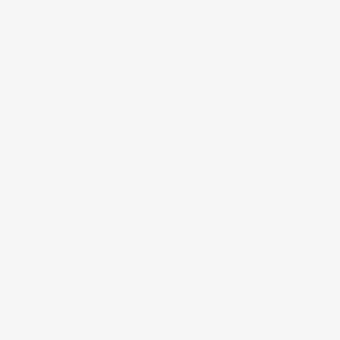
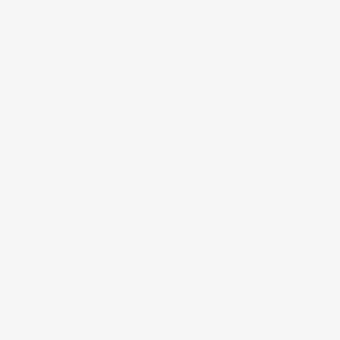
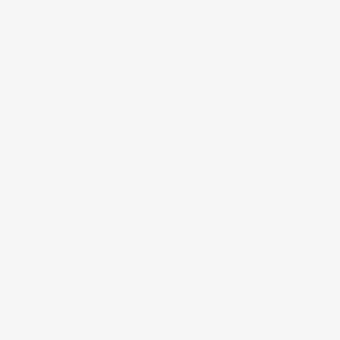
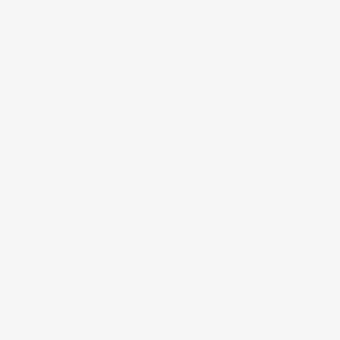
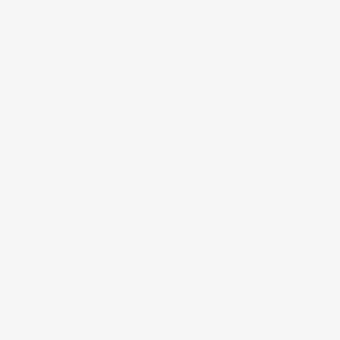
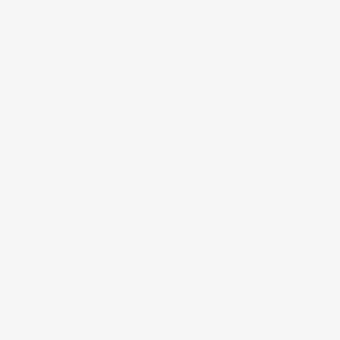
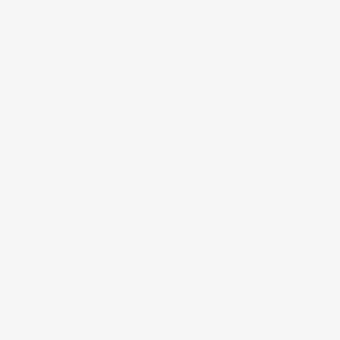
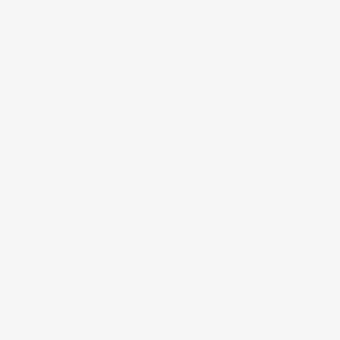
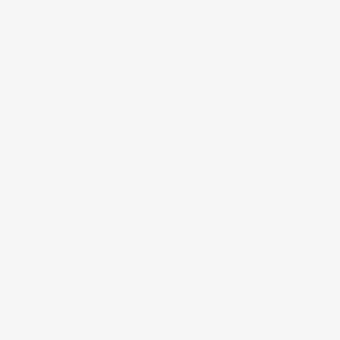
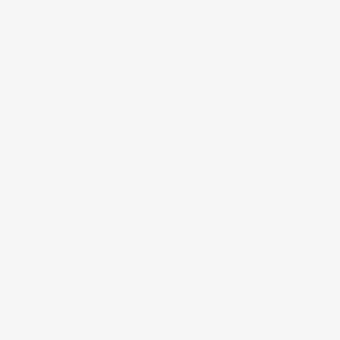
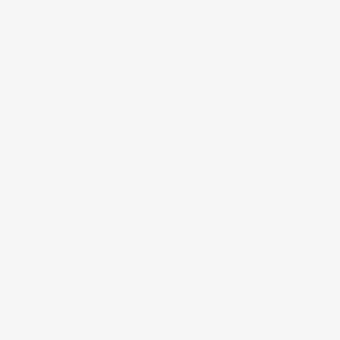
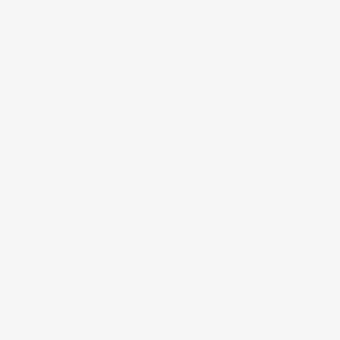
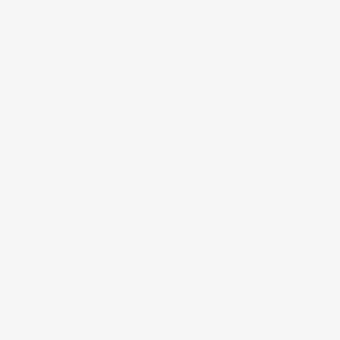
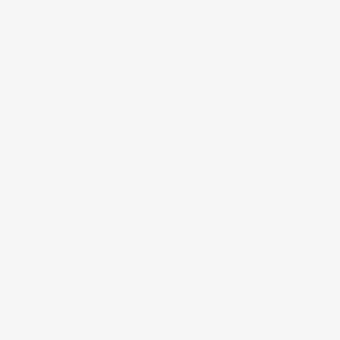
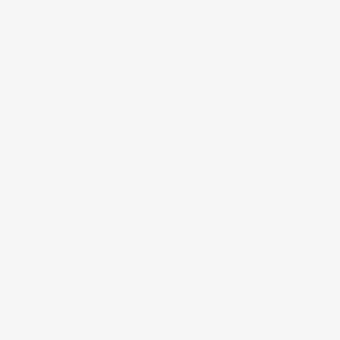
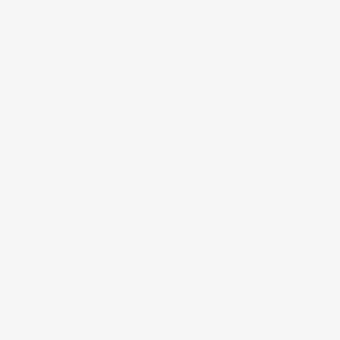
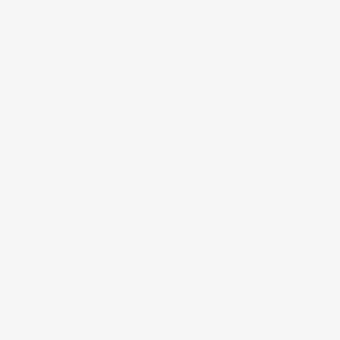
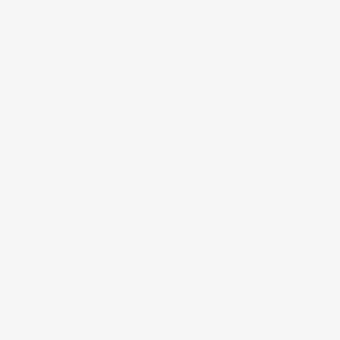
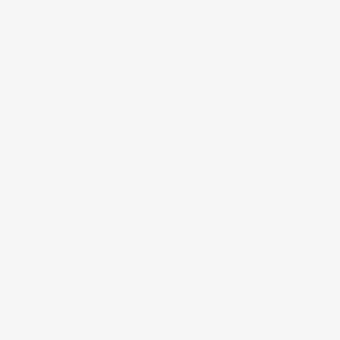
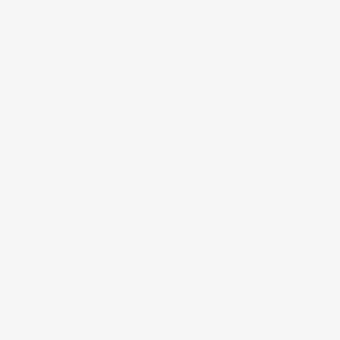
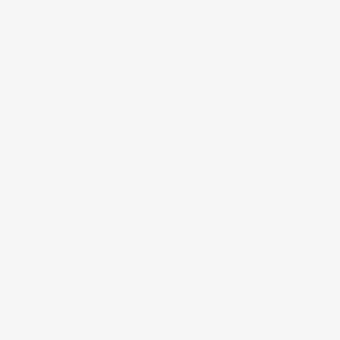
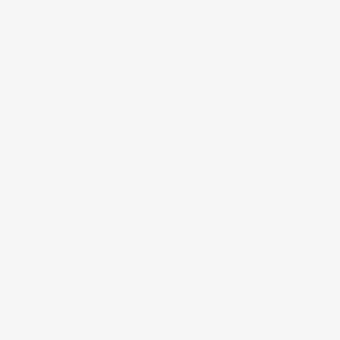
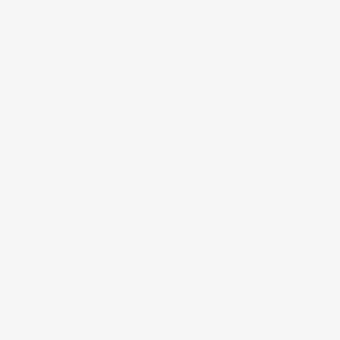
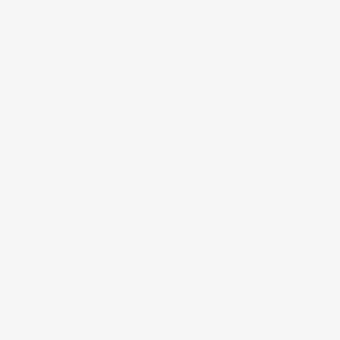
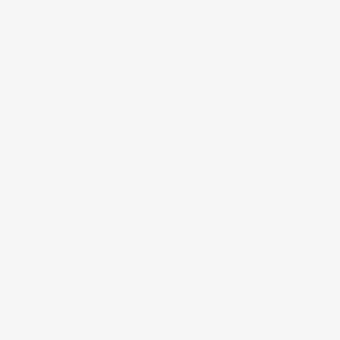
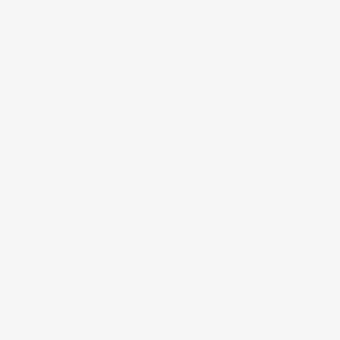
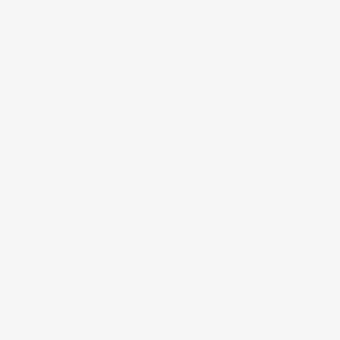
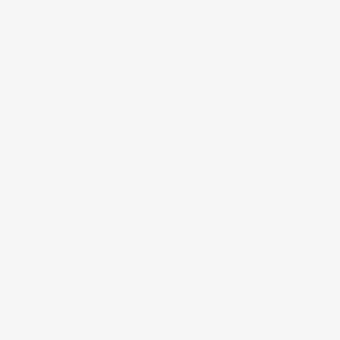
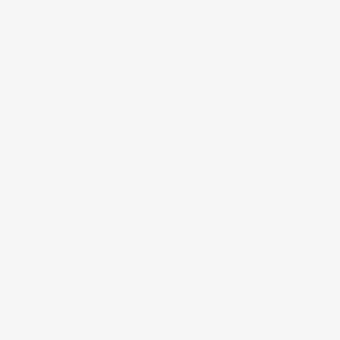
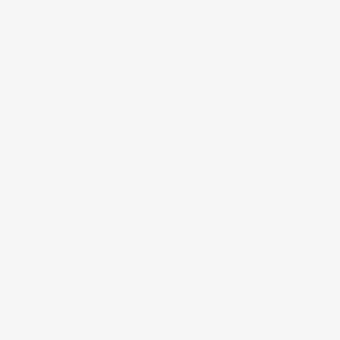
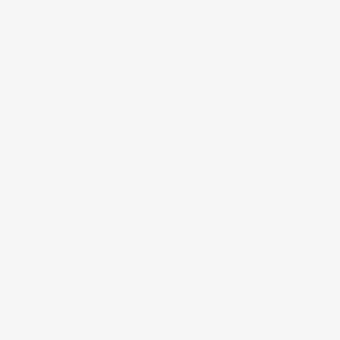
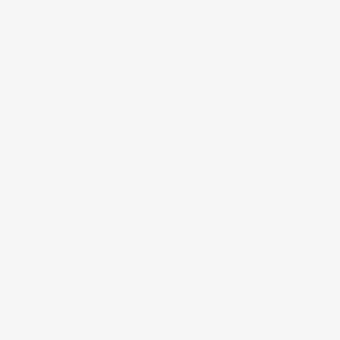
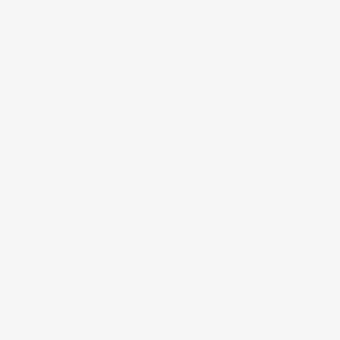
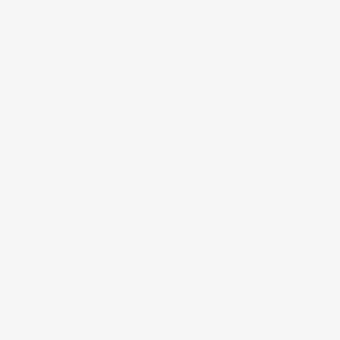
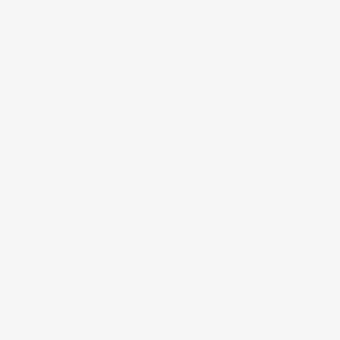
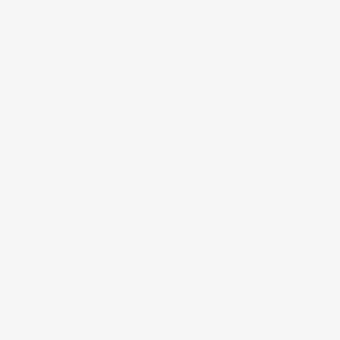
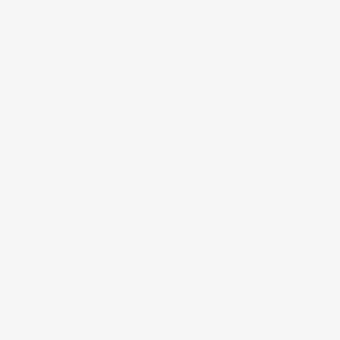
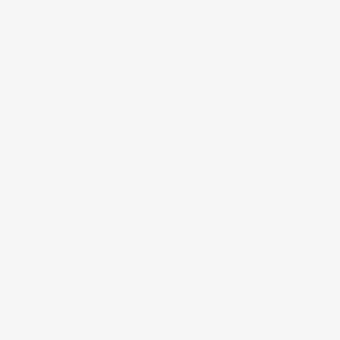
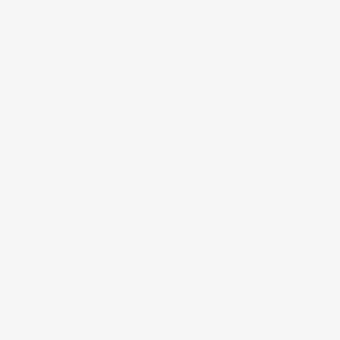
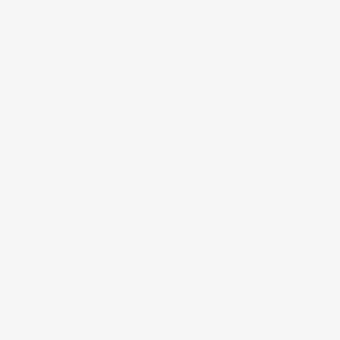
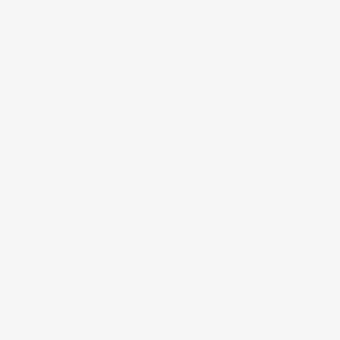
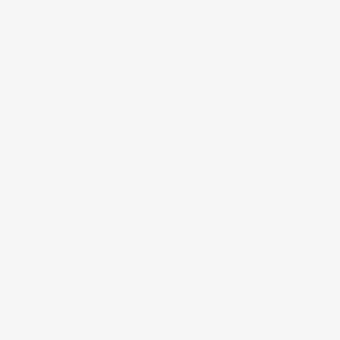
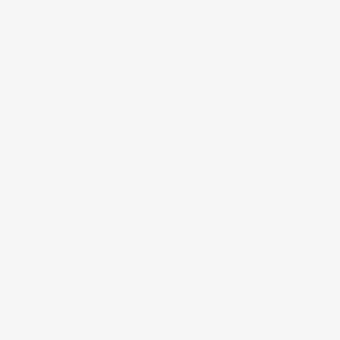
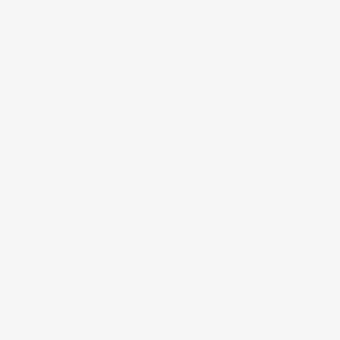
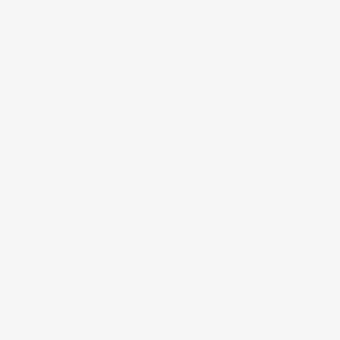
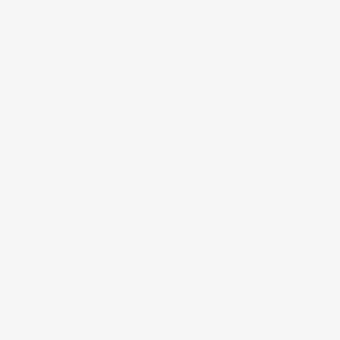
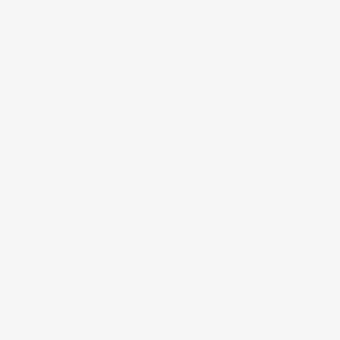
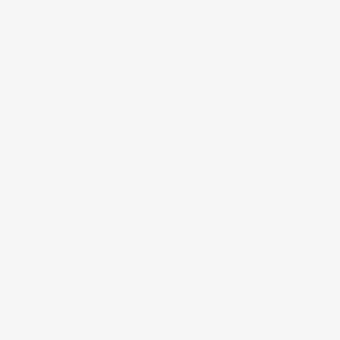
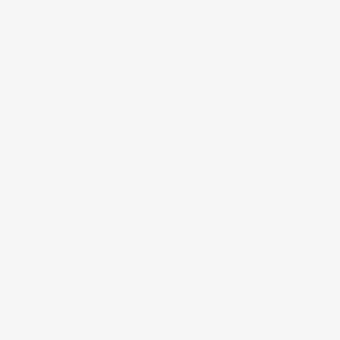
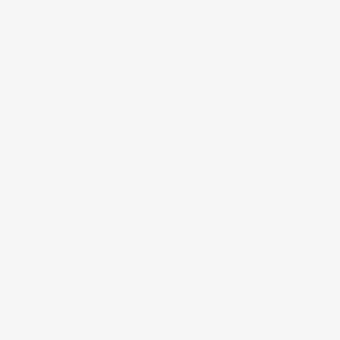
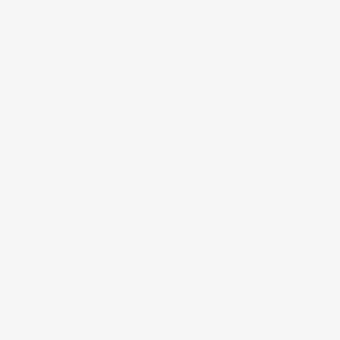
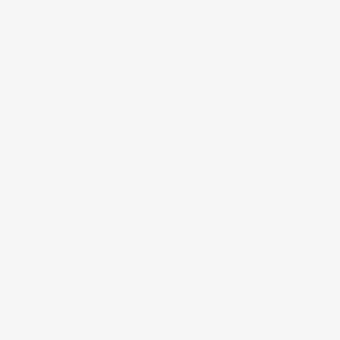
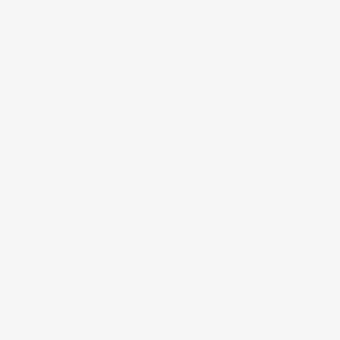
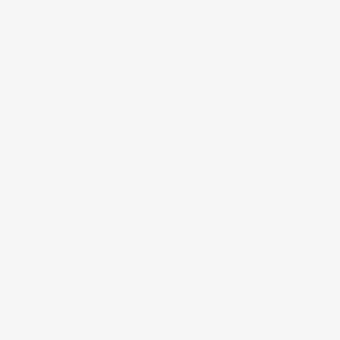
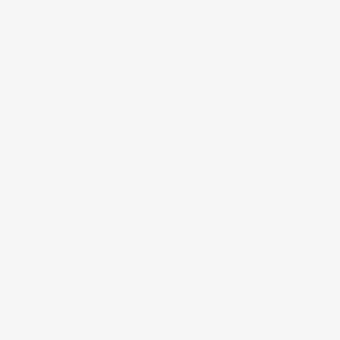
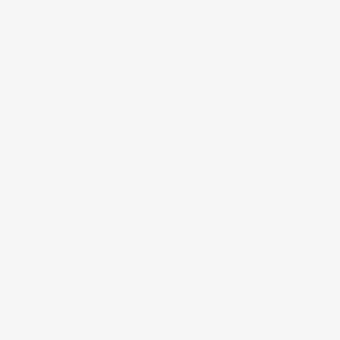
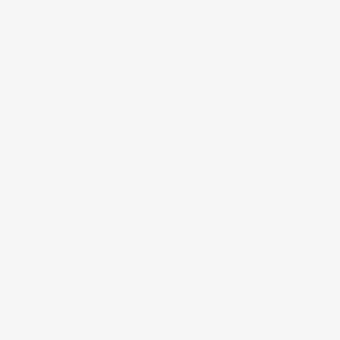
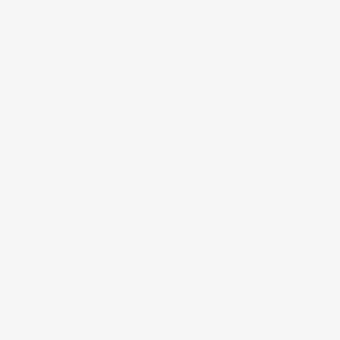
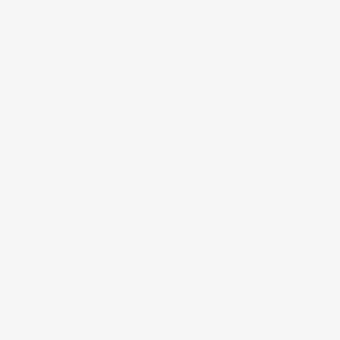
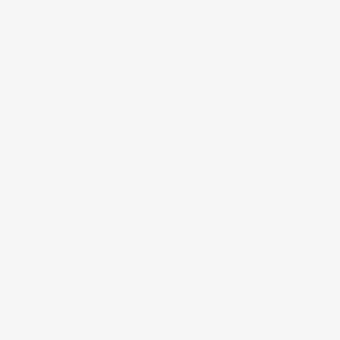
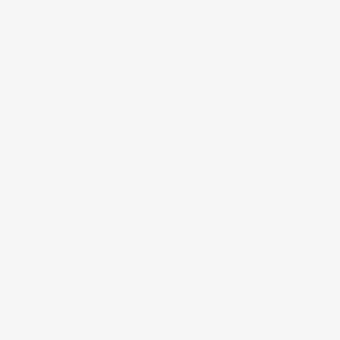
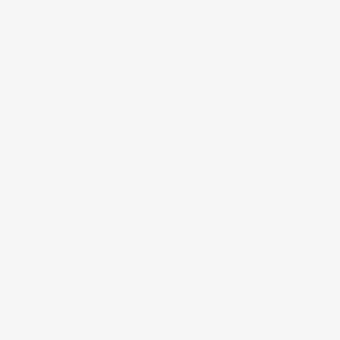
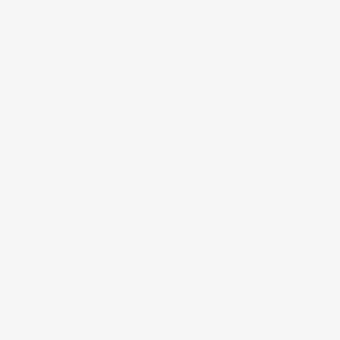
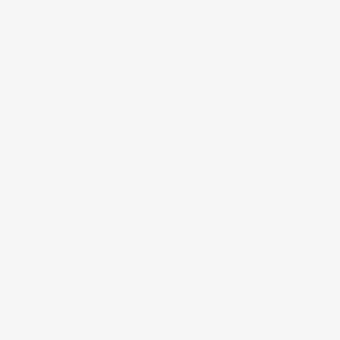
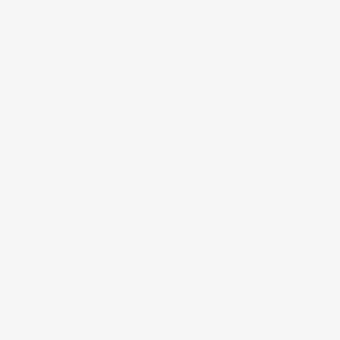
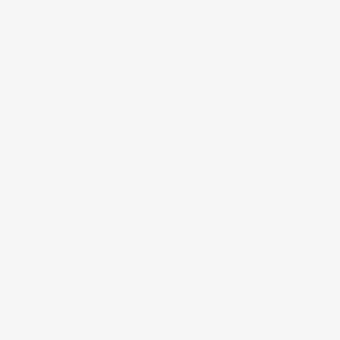
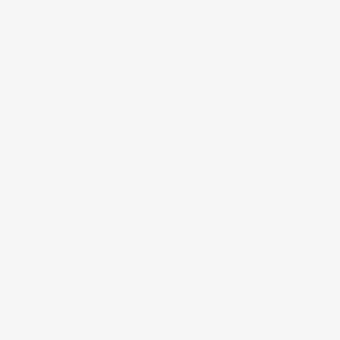
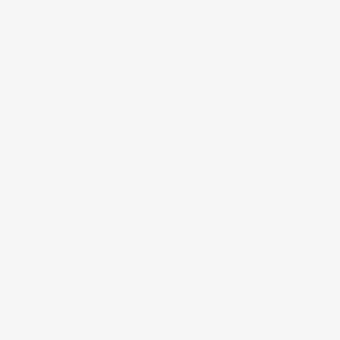
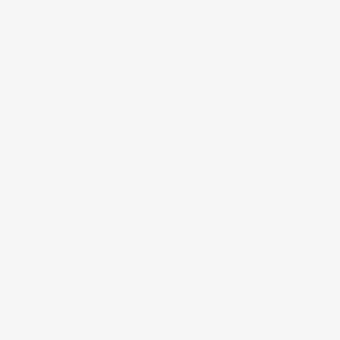
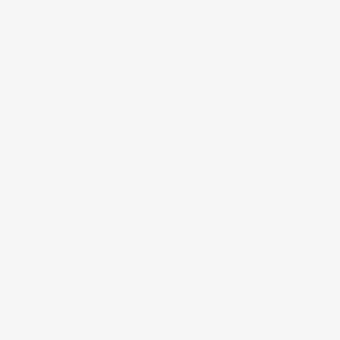
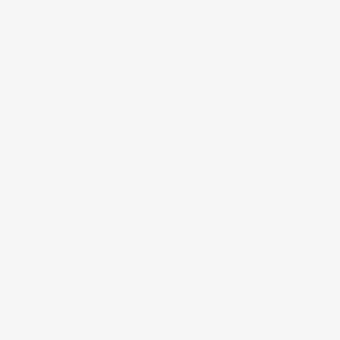
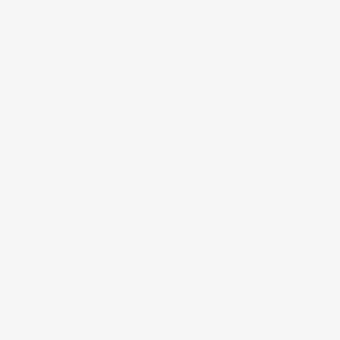
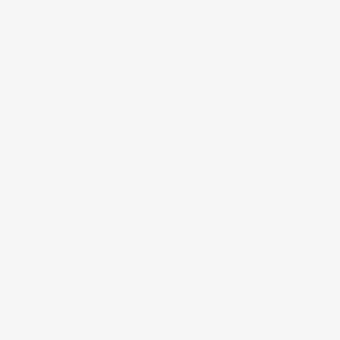
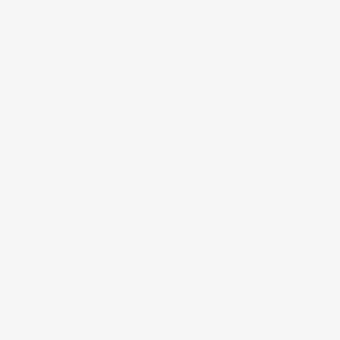
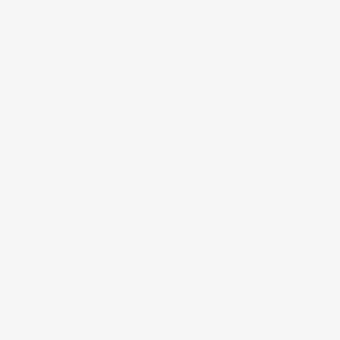
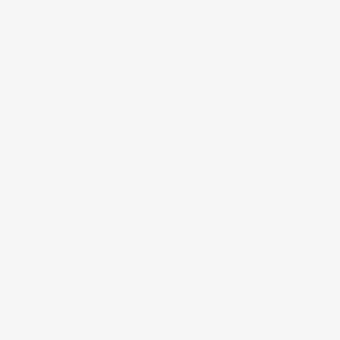
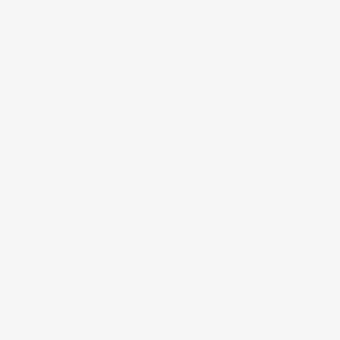
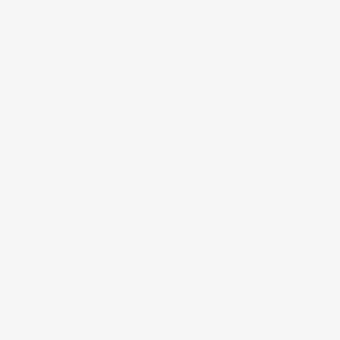
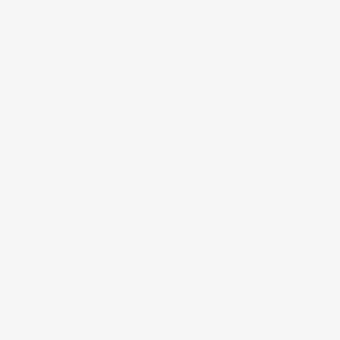
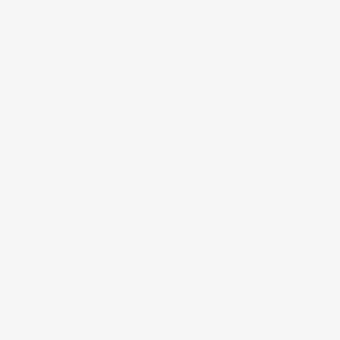
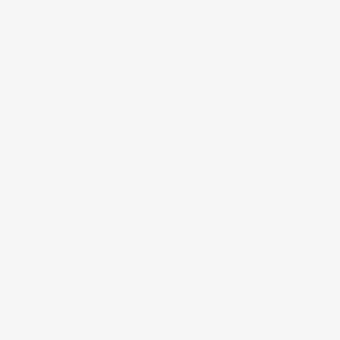
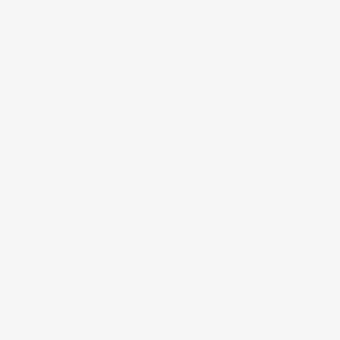
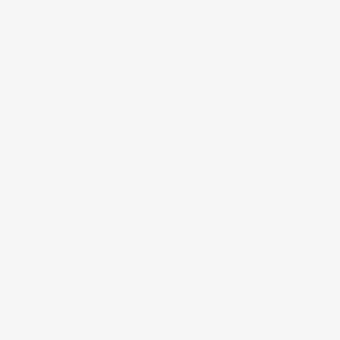
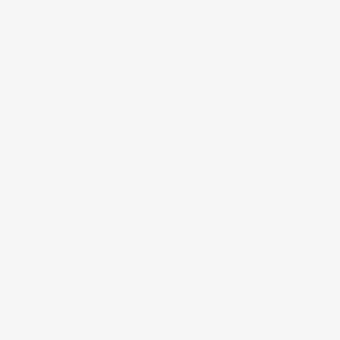
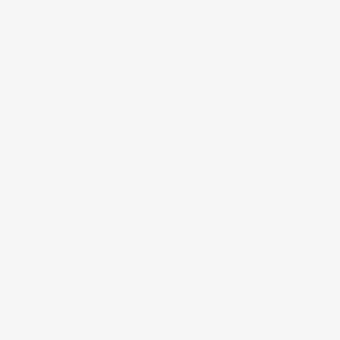
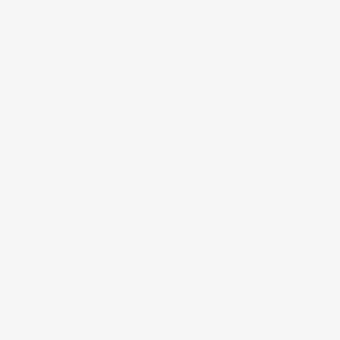
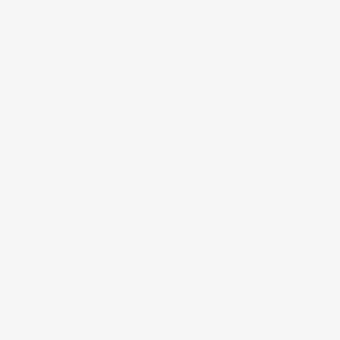
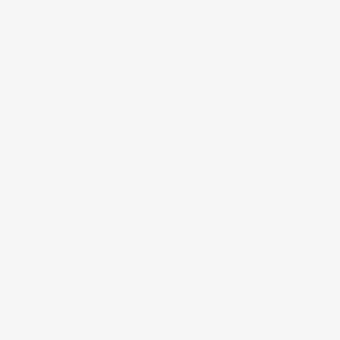
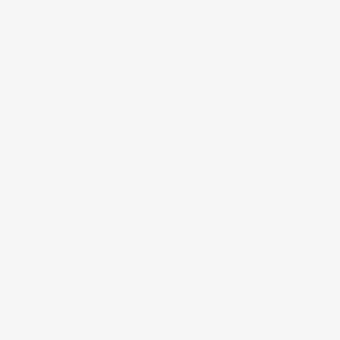
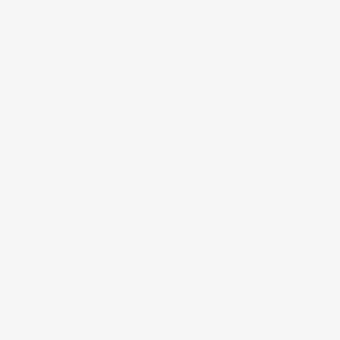
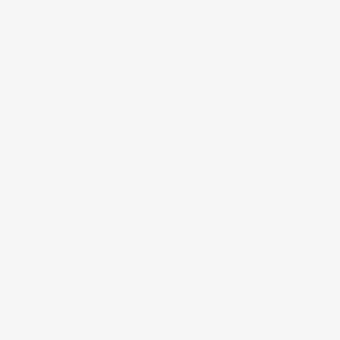
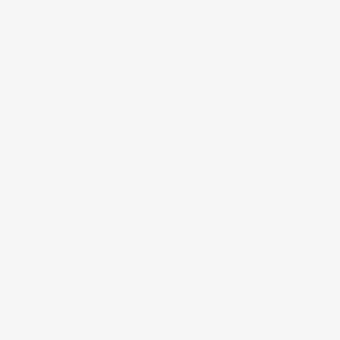
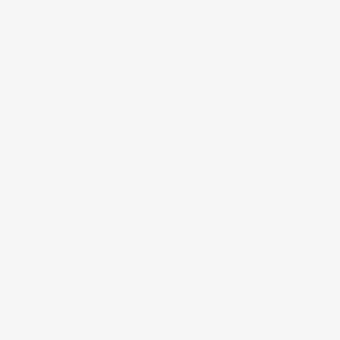
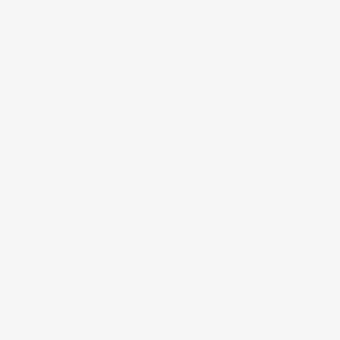
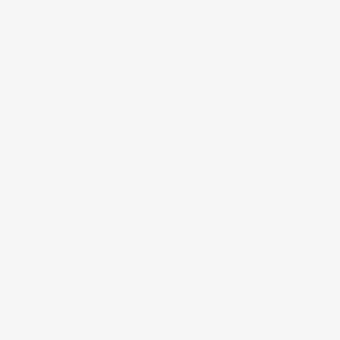
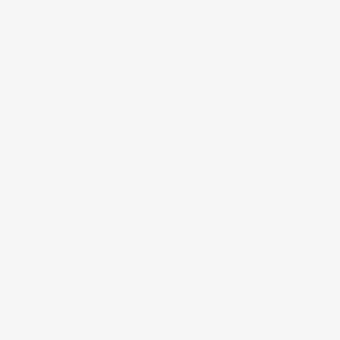
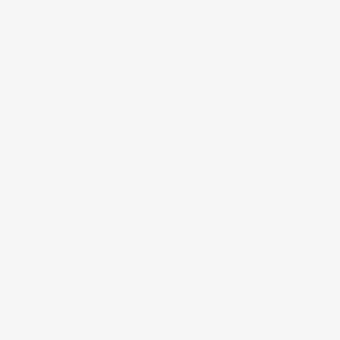
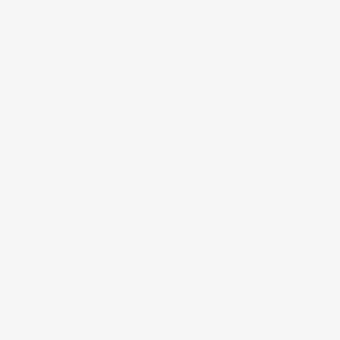
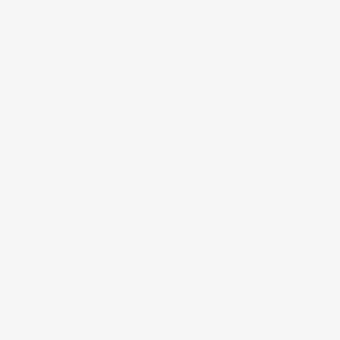
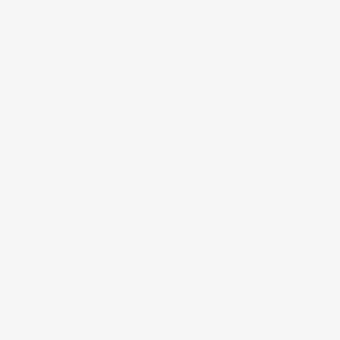
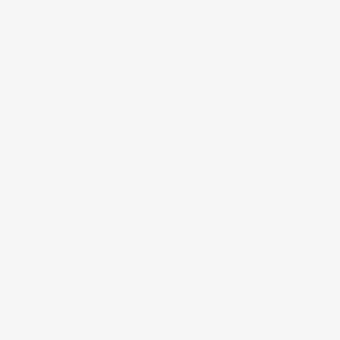
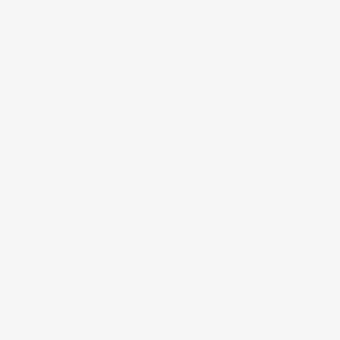
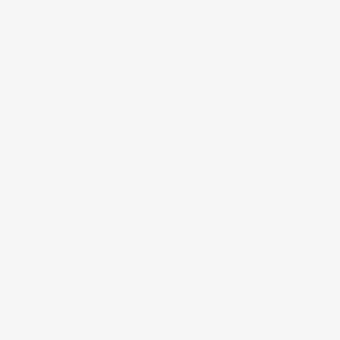
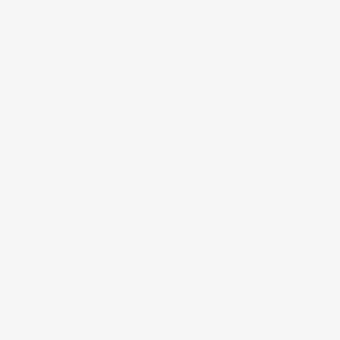
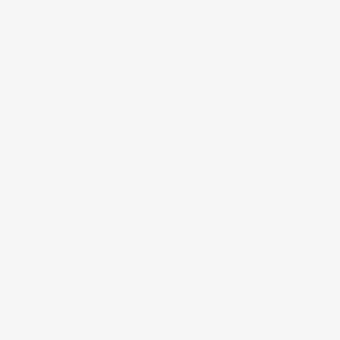
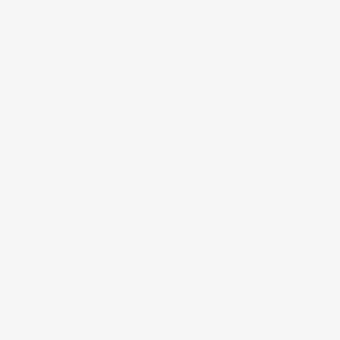
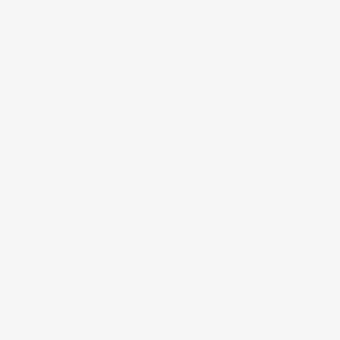
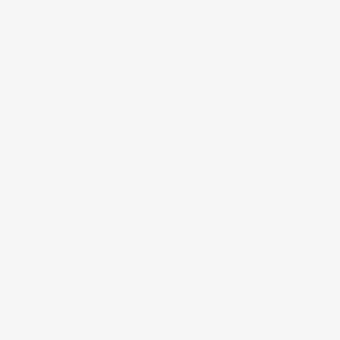
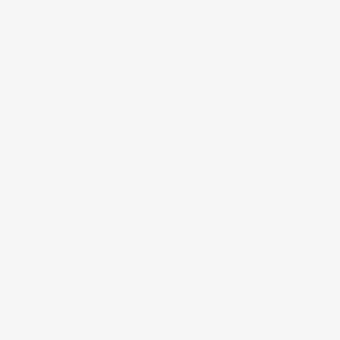
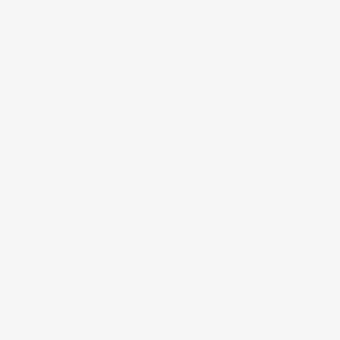
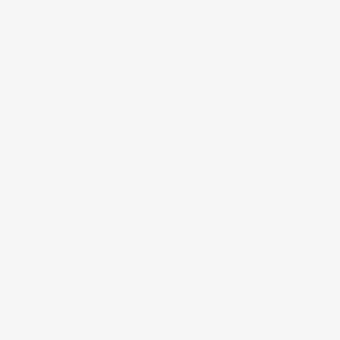
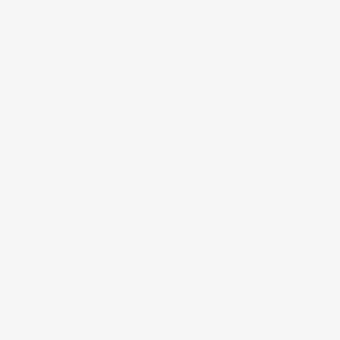
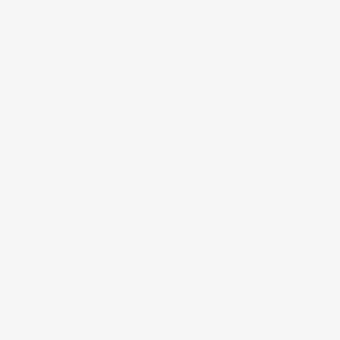
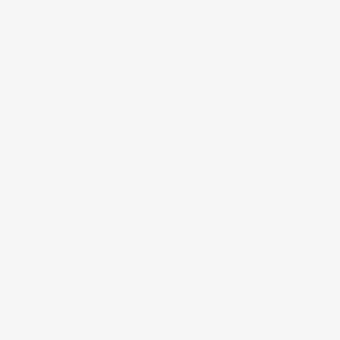
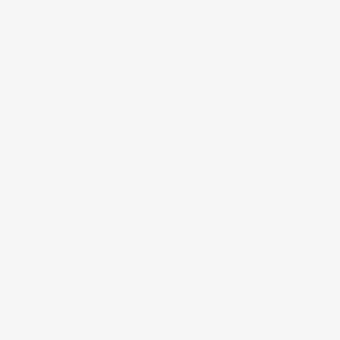
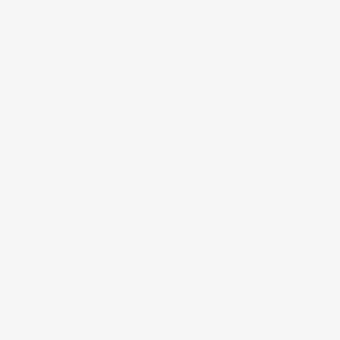
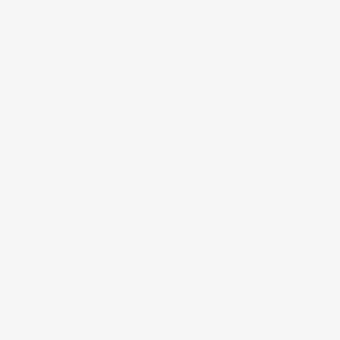
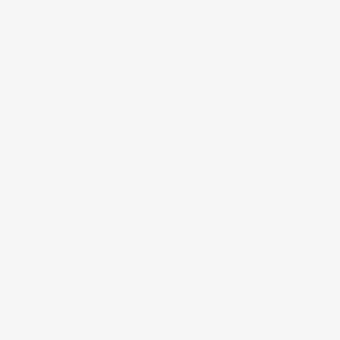
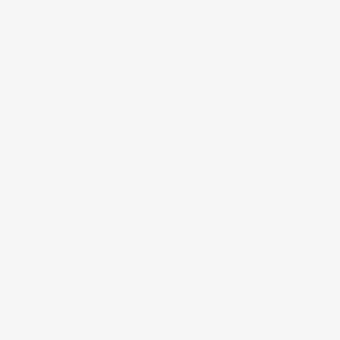
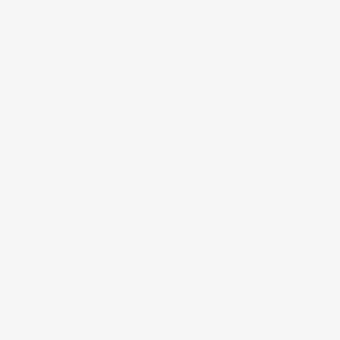

In [1]:
import os
import re
import time
import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException
import logging
from urllib.parse import urljoin
from webdriver_manager.chrome import ChromeDriverManager

# ======== System Configuration ==========
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('crawler.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('Crawler')

# General configuration
HEADERS = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.9,vi;q=0.8',
}

USER_AGENTS = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0',
    'Mozilla/5.0 (iPhone; CPU iPhone OS 16_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.6 Mobile/15E148 Safari/604.1'
]

# Crawler parameters
IMAGE_DIR = 'images'
os.makedirs(IMAGE_DIR, exist_ok=True)
MAX_PAGES = 2
PRODUCTS_PER_PAGE = 40
DELAY_RANGE = (1.5, 4.0)
MAX_RETRIES = 3
TIMEOUT = 30

# Tiki categories
TIKI_CATEGORIES = [
    {"id": 1795, "name": "Điện thoại"},
    {"id": 1805, "name": "Loa"},
    {"id": 1811, "name": "Tai nghe"},
    {"id": 1821, "name": "Sạc dự phòng"},
    {"id": 3428, "name": "Chuột"},
    {"id": 8039, "name": "Đồng hồ thông minh"},
]

# TGDD categories
TGDD_CATEGORIES = [
    {"url": "https://www.thegioididong.com/dtdd", "name": "Điện thoại", "item_selector": "li.item", "price_selector": ".price"},
    {"url": "https://www.thegioididong.com/dong-ho-thong-minh", "name": "Đồng hồ thông minh", "item_selector": "li.item", "price_selector": ".price"},
    {"url": "https://www.thegioididong.com/loa-laptop", "name": "Loa", "item_selector": "li.item", "price_selector": ".price"},
    {"url": "https://www.thegioididong.com/tai-nghe-bluetooth", "name": "Tai nghe", "item_selector": "li.item", "price_selector": ".price"},
    {"url": "https://www.thegioididong.com/sac-dtdd", "name": "Sạc dự phòng", "item_selector": "li.item", "price_selector": ".price"},
    {"url": "https://www.thegioididong.com/chuot-may-tinh", "name": "Chuột", "item_selector": "li.item", "price_selector": ".price"}
]

# Lazada categories
LAZADA_CATEGORIES = [
    {"url": "https://www.lazada.vn/dien-thoai-di-dong/", "name": "Điện thoại"},
    {"url": "https://www.lazada.vn/shop-portable-speakers-&-boomboxes/", "name": "Loa"},
    {"url": "https://www.lazada.vn/shop-wireless-earbuds/", "name": "Tai nghe"},
    {"url": "https://www.lazada.vn/pin-sac-du-phong/", "name": "Sạc dự phòng"},
    {"url": "https://www.lazada.vn/chuot-co-ban/", "name": "Chuột"},
    {"url": "https://www.lazada.vn/shop-smartwatch-&-fitness-trackers/", "name": "Đồng hồ thông minh"},
]

# ======== Helper Functions ==========
def get_random_headers():
    return {**HEADERS, 'User-Agent': random.choice(USER_AGENTS)}

def sanitize_filename(filename):
    return re.sub(r'[\\/*?:"<>|]', "", str(filename)).strip()[:100]

def random_delay():
    time.sleep(random.uniform(*DELAY_RANGE))

def init_driver():
    """Initialize WebDriver with anti-detection configuration"""
    try:
        chrome_options = Options()
        chrome_options.add_argument("--headless=new")
        chrome_options.add_argument("--disable-blink-features=AutomationControlled")
        chrome_options.add_argument(f"user-agent={random.choice(USER_AGENTS)}")
        chrome_options.add_argument("--window-size=1920,1080")
        
        # Automatically download and manage ChromeDriver
        service = ChromeService(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=chrome_options)
        
        # Add script to hide automation
        driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
            "source": """
            Object.defineProperty(navigator, 'webdriver', {
                get: () => undefined
            })
            window.navigator.chrome = undefined;
            """
        })
        
        driver.set_page_load_timeout(TIMEOUT)
        return driver
    except Exception as e:
        logger.error(f"WebDriver initialization error: {e}")
        return None

def download_image(image_url, product_id, category_dir):
    """Download and save product image with retry"""
    if not image_url or not product_id:
        return ""
    
    product_id = sanitize_filename(product_id)
    if not product_id:
        return ""
    
    if image_url.startswith("//"):
        image_url = "https:" + image_url
    
    for attempt in range(MAX_RETRIES):
        try:
            response = requests.get(
                image_url,
                headers=get_random_headers(),
                timeout=TIMEOUT,
                stream=True
            )
            response.raise_for_status()
            
            if 'image' not in response.headers.get('Content-Type', ''):
                logger.warning(f"URL is not an image: {image_url}")
                return ""
                
            file_ext = os.path.splitext(image_url)[1][:4] or '.jpg'
            filename = f"{product_id}_{hash(image_url)}{file_ext}"
            filepath = os.path.join(category_dir, filename)
            
            with open(filepath, "wb") as f:
                for chunk in response.iter_content(1024):
                    if chunk:
                        f.write(chunk)
            
            return os.path.join(os.path.basename(category_dir), filename)
        except Exception as e:
            logger.warning(f"Image download error (attempt {attempt + 1}): {e}")
            if attempt == MAX_RETRIES - 1:
                return ""
            time.sleep(random.uniform(1, 3))
    
    return ""

# ======== TGDD Crawler ==========
def crawl_tgdd_category(url, category_name, item_selector, price_selector):
    """Crawl products from TGDD with dynamic selectors"""
    logger.info(f"[TGDD] Starting crawl for '{category_name}'")
    records = []
    category_dir = os.path.join(IMAGE_DIR, category_name.replace(" ", "_"))
    os.makedirs(category_dir, exist_ok=True)

    driver = init_driver()
    if not driver:
        return records

    try:
        for page in range(1, MAX_PAGES + 1):
            page_url = f"{url}?p={page}"
            logger.info(f"Crawling: {page_url}")
            
            for attempt in range(MAX_RETRIES):
                try:
                    driver.get(page_url)
                    
                    # Wait for multiple possible conditions
                    WebDriverWait(driver, 20).until(
                        EC.any_of(
                            EC.presence_of_element_located((By.CSS_SELECTOR, item_selector)),
                            EC.presence_of_element_located((By.CSS_SELECTOR, ".listproduct"))
                        )
                    )
                    
                    # Simulate user behavior
                    for _ in range(2):
                        driver.execute_script("window.scrollBy(0, window.innerHeight * 0.8)")
                        time.sleep(1.5)
                    
                    soup = BeautifulSoup(driver.page_source, 'html.parser')
                    items = soup.select(item_selector)
                    
                    if not items:
                        logger.warning(f"No products found at {page_url}")
                        break

                    for item in items:
                        try:
                            # Product name
                            name = (item.select_one("h3") or 
                                item.select_one(".product-name") or 
                                item.select_one(".name")).get_text(strip=True)
                            
                            # Product price - check multiple selectors
                            price = 0
                            price_tags = [
                                item.select_one(price_selector),
                                item.select_one(".price-now"),
                                item.select_one(".product-price__current-price"),
                                item.select_one(".final-price")
                            ]
                            
                            for tag in price_tags:
                                if tag:
                                    price_str = re.sub(r"[^\d]", "", tag.get_text(strip=True))
                                    if price_str.isdigit():
                                        price = int(price_str)
                                        break
                            
                            # Image URL
                            img = item.select_one("img")
                            image_url = (img.get("data-src") or 
                                    img.get("src") or 
                                    img.get("data-original", "")).strip()
                            
                            # Product URL
                            link = item.select_one("a")
                            source = urljoin("https://www.thegioididong.com", link["href"]) if link else ""
                            
                            # Product ID
                            product_id = re.search(r"/(\d+)$", source)
                            product_id = product_id.group(1) if product_id else str(hash(name))
                            
                            # Download image
                            image_file = download_image(image_url, product_id, category_dir)

                            records.append({
                                "product_id": product_id,
                                "product_name": name,
                                "category": category_name,
                                "price": price,
                                "image": image_file,
                                "image_url": image_url,
                                "source": source,
                                "platform": "TGDD"
                            })
                            
                        except Exception as e:
                            logger.error(f"Product processing error: {str(e)[:100]}...")
                            continue
                    
                    break  # Exit retry loop if successful
                
                except TimeoutException:
                    logger.warning(f"Timeout (attempt {attempt + 1}) at {page_url}")
                    if attempt == MAX_RETRIES - 1:
                        break
                    time.sleep(5)
                except Exception as e:
                    logger.error(f"Error (attempt {attempt + 1}) at {page_url}: {str(e)[:200]}...")
                    if attempt == MAX_RETRIES - 1:
                        break
                    time.sleep(5)
            
            random_delay()
                
    except Exception as e:
        logger.error(f"System error: {e}")
    finally:
        driver.quit()
    
    logger.info(f"Completed {category_name}: {len(records)} products")
    return records

# ======== Tiki Crawler ==========
def crawl_tiki_category(category_id, category_name):
    """Crawl products from Tiki using API"""
    logger.info(f"[TIKI] Starting crawl for '{category_name}'")
    records = []
    category_dir = os.path.join(IMAGE_DIR, category_name.replace(" ", "_"))
    os.makedirs(category_dir, exist_ok=True)

    for page in range(1, MAX_PAGES + 1):
        logger.info(f"Crawling page {page}")
        url = "https://tiki.vn/api/v2/products"
        params = {
            "limit": PRODUCTS_PER_PAGE,
            "category": category_id,
            "page": page,
            "sort": "top_seller"
        }

        for attempt in range(MAX_RETRIES):
            try:
                response = requests.get(
                    url,
                    headers=get_random_headers(),
                    params=params,
                    timeout=TIMEOUT
                )
                
                if response.status_code == 404:
                    logger.info("No more pages")
                    return records
                
                response.raise_for_status()
                data = response.json()
                
                for item in data.get('data', []):
                    try:
                        product_id = str(item.get('id', ''))
                        name = item.get('name', '')
                        price = item.get('price', 0)
                        image_url = item.get('thumbnail_url', '')
                        url_path = item.get('url_path', '')
                        
                        # Download image
                        image_file = download_image(image_url, product_id, category_dir)
                        
                        records.append({
                            "product_id": product_id,
                            "product_name": name,
                            "category": category_name,
                            "price": price,
                            "image": image_file,
                            "image_url": image_url,
                            "source": f"https://tiki.vn/{url_path}",
                            "platform": "Tiki"
                        })
                    
                    except Exception as e:
                        logger.error(f"Product processing error: {e}")
                        continue
                
                break  # Exit retry loop if successful
            
            except requests.exceptions.RequestException as e:
                logger.warning(f"Request error (attempt {attempt + 1}): {e}")
                if attempt == MAX_RETRIES - 1:
                    break
                time.sleep(5)
        
        random_delay()

    logger.info(f"Completed {category_name}: {len(records)} products")
    return records

# ======== Lazada Crawler ==========
def crawl_lazada_category(url, category_name):
    """Crawl products from Lazada"""
    logger.info(f"[LAZADA] Starting crawl for '{category_name}'")
    records = []
    category_dir = os.path.join(IMAGE_DIR, category_name.replace(" ", "_"))
    os.makedirs(category_dir, exist_ok=True)

    driver = init_driver()
    if not driver:
        return records

    try:
        driver.get(url)
        WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "[data-qa-locator='product-item']"))
        )

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        items = soup.select("[data-qa-locator='product-item']")

        for item in items:
            try:
                name = item.select_one(".RfADt") and item.select_one(".RfADt").get_text(strip=True)
                price = item.select_one(".aBrP0") and item.select_one(".aBrP0").get_text(strip=True)
                price = int(re.sub(r"[^\d]", "", price)) if price else 0
                
                img = item.select_one(".Bm3ON img")
                image_url = img.get("src") if img else ""
                
                link = item.select_one("a")
                source = urljoin("https://www.lazada.vn", link["href"]) if link else ""
                
                product_id = re.search(r"-i(\d+)-s", source)
                product_id = product_id.group(1) if product_id else str(hash(name))
                
                image_file = download_image(image_url, product_id, category_dir)

                records.append({
                    "product_id": product_id,
                    "product_name": name,
                    "category": category_name,
                    "price": price,
                    "image": image_file,
                    "image_url": image_url,
                    "source": source,
                    "platform": "Lazada"
                })
            except Exception as e:
                logger.error(f"Lazada product error: {e}")
                continue

    except Exception as e:
        logger.error(f"Lazada crawl error: {e}")
    finally:
        driver.quit()

    logger.info(f"Completed {category_name}: {len(records)} products")
    return records

# ======== Main Function ==========
def main():
    start_time = time.time()
    all_products = []

    try:
        # Crawl Tiki
        for cat in TIKI_CATEGORIES:
            try:
                products = crawl_tiki_category(cat["id"], cat["name"])
                all_products.extend(products)
            except Exception as e:
                logger.error(f"Tiki error {cat['name']}: {e}")

        # Crawl TGDD
        for cat in TGDD_CATEGORIES:
            try:
                products = crawl_tgdd_category(
                    cat["url"],
                    cat["name"],
                    cat["item_selector"],
                    cat["price_selector"]
                )
                all_products.extend(products)
            except Exception as e:
                logger.error(f"TGDD error {cat['name']}: {e}")

        # Crawl Lazada
        for cat in LAZADA_CATEGORIES:
            try:
                products = crawl_lazada_category(cat["url"], cat["name"])
                all_products.extend(products)
            except Exception as e:
                logger.error(f"Lazada error {cat['name']}: {e}")
        
        # Save data
        if all_products:
            df = pd.DataFrame(all_products)
            
            # Data cleaning
            df['product_name'] = df['product_name'].str.replace(r'[\x00-\x1F\x7F-\x9F]', '', regex=True)
            df['category'] = df['category'].str.replace(r'[\\/*?:"<>|]', '', regex=True)
            
            # Save file
            try:
                df.to_excel("data.xlsx", index=False, engine='openpyxl')
                logger.info(f"Saved {len(all_products)} shuffled products")
            except Exception as e:
                logger.error(f"Excel save error: {e}")
                df.to_csv("data.csv", index=False, encoding='utf-8-sig')
        else:
            logger.warning("No products were crawled")

    except Exception as e:
        logger.error(f"Program error: {e}")
    finally:
        logger.info(f"Total execution time: {time.time() - start_time:.2f}s")

if __name__ == "__main__":
    main()